In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import ladyns as ldn

In [5]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [6]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [7]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [8]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 10

In [9]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [10]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

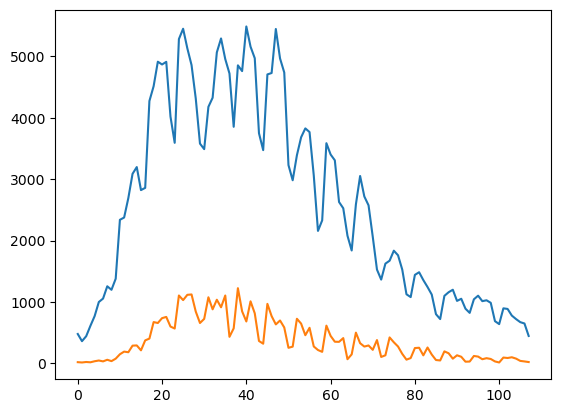

In [11]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [12]:
GPi = np.load('EuropeCovid2_GPi.npz')

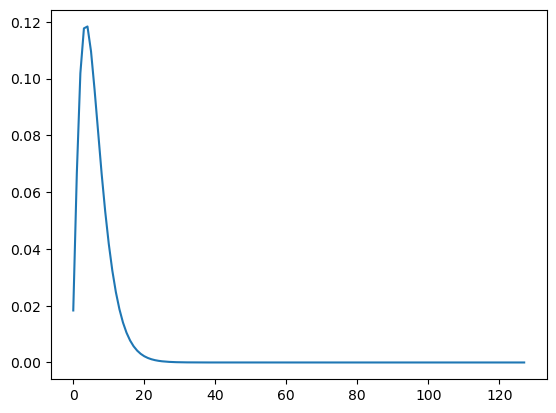

In [13]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

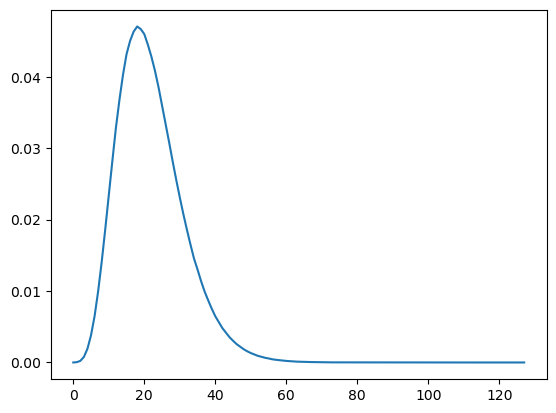

In [14]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [15]:
# A
d=2
A = np.zeros([T+T0, d])

In [16]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

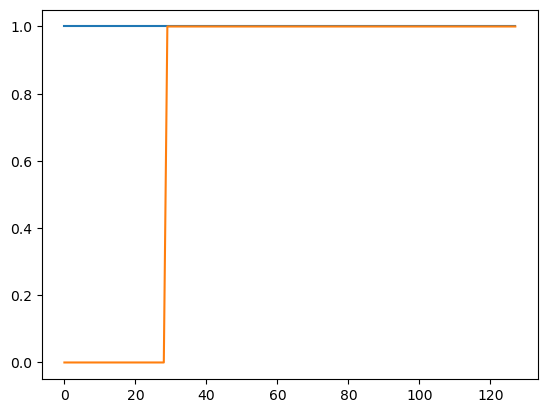

In [17]:
plt.plot(A)

# 3. fit by EM algorithm

In [18]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [19]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [20]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [21]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat=binit
    ss=np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/1000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = rhat + ss * dth[0]
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [23]:
rmle = 5.2
mmle_0 = 2.5
bmle = [-0.35, 2.5]

In [27]:
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=1)

Before EM, ll: -647.411355
1-th iteration finished, ll: -647.410258, lapse: 0.014sec.
2-th iteration finished, ll: -647.409163, lapse: 0.014sec.
3-th iteration finished, ll: -647.408070, lapse: 0.007sec.
4-th iteration finished, ll: -647.406979, lapse: 0.005sec.
5-th iteration finished, ll: -647.405890, lapse: 0.005sec.
6-th iteration finished, ll: -647.404804, lapse: 0.005sec.
7-th iteration finished, ll: -647.403719, lapse: 0.005sec.
8-th iteration finished, ll: -647.402636, lapse: 0.009sec.
9-th iteration finished, ll: -647.401556, lapse: 0.010sec.
10-th iteration finished, ll: -647.400478, lapse: 0.004sec.
11-th iteration finished, ll: -647.399401, lapse: 0.004sec.
12-th iteration finished, ll: -647.398327, lapse: 0.009sec.
13-th iteration finished, ll: -647.397255, lapse: 0.010sec.
14-th iteration finished, ll: -647.396185, lapse: 0.007sec.
15-th iteration finished, ll: -647.395117, lapse: 0.005sec.
16-th iteration finished, ll: -647.394051, lapse: 0.005sec.
17-th iteration finish

155-th iteration finished, ll: -647.263661, lapse: 0.018sec.
156-th iteration finished, ll: -647.262837, lapse: 0.011sec.
157-th iteration finished, ll: -647.262014, lapse: 0.012sec.
158-th iteration finished, ll: -647.261192, lapse: 0.018sec.
159-th iteration finished, ll: -647.260372, lapse: 0.009sec.
160-th iteration finished, ll: -647.259554, lapse: 0.007sec.
161-th iteration finished, ll: -647.258736, lapse: 0.007sec.
162-th iteration finished, ll: -647.257921, lapse: 0.008sec.
163-th iteration finished, ll: -647.257106, lapse: 0.009sec.
164-th iteration finished, ll: -647.256293, lapse: 0.009sec.
165-th iteration finished, ll: -647.255482, lapse: 0.006sec.
166-th iteration finished, ll: -647.254672, lapse: 0.006sec.
167-th iteration finished, ll: -647.253863, lapse: 0.008sec.
168-th iteration finished, ll: -647.253056, lapse: 0.007sec.
169-th iteration finished, ll: -647.252250, lapse: 0.008sec.
170-th iteration finished, ll: -647.251446, lapse: 0.011sec.
171-th iteration finishe

295-th iteration finished, ll: -647.160920, lapse: 0.008sec.
296-th iteration finished, ll: -647.160269, lapse: 0.018sec.
297-th iteration finished, ll: -647.159619, lapse: 0.006sec.
298-th iteration finished, ll: -647.158970, lapse: 0.009sec.
299-th iteration finished, ll: -647.158322, lapse: 0.009sec.
300-th iteration finished, ll: -647.157675, lapse: 0.004sec.
301-th iteration finished, ll: -647.157029, lapse: 0.010sec.
302-th iteration finished, ll: -647.156384, lapse: 0.007sec.
303-th iteration finished, ll: -647.155740, lapse: 0.004sec.
304-th iteration finished, ll: -647.155097, lapse: 0.005sec.
305-th iteration finished, ll: -647.154455, lapse: 0.009sec.
306-th iteration finished, ll: -647.153814, lapse: 0.004sec.
307-th iteration finished, ll: -647.153175, lapse: 0.004sec.
308-th iteration finished, ll: -647.152536, lapse: 0.005sec.
309-th iteration finished, ll: -647.151898, lapse: 0.010sec.
310-th iteration finished, ll: -647.151262, lapse: 0.004sec.
311-th iteration finishe

443-th iteration finished, ll: -647.074910, lapse: 0.012sec.
444-th iteration finished, ll: -647.074393, lapse: 0.009sec.
445-th iteration finished, ll: -647.073876, lapse: 0.014sec.
446-th iteration finished, ll: -647.073361, lapse: 0.009sec.
447-th iteration finished, ll: -647.072846, lapse: 0.005sec.
448-th iteration finished, ll: -647.072332, lapse: 0.007sec.
449-th iteration finished, ll: -647.071819, lapse: 0.004sec.
450-th iteration finished, ll: -647.071307, lapse: 0.004sec.
451-th iteration finished, ll: -647.070795, lapse: 0.005sec.
452-th iteration finished, ll: -647.070285, lapse: 0.004sec.
453-th iteration finished, ll: -647.069774, lapse: 0.004sec.
454-th iteration finished, ll: -647.069265, lapse: 0.009sec.
455-th iteration finished, ll: -647.068757, lapse: 0.008sec.
456-th iteration finished, ll: -647.068249, lapse: 0.011sec.
457-th iteration finished, ll: -647.067742, lapse: 0.006sec.
458-th iteration finished, ll: -647.067236, lapse: 0.005sec.
459-th iteration finishe

589-th iteration finished, ll: -647.006943, lapse: 0.012sec.
590-th iteration finished, ll: -647.006525, lapse: 0.011sec.
591-th iteration finished, ll: -647.006108, lapse: 0.011sec.
592-th iteration finished, ll: -647.005691, lapse: 0.005sec.
593-th iteration finished, ll: -647.005275, lapse: 0.005sec.
594-th iteration finished, ll: -647.004859, lapse: 0.006sec.
595-th iteration finished, ll: -647.004444, lapse: 0.006sec.
596-th iteration finished, ll: -647.004030, lapse: 0.005sec.
597-th iteration finished, ll: -647.003616, lapse: 0.006sec.
598-th iteration finished, ll: -647.003203, lapse: 0.011sec.
599-th iteration finished, ll: -647.002790, lapse: 0.005sec.
600-th iteration finished, ll: -647.002378, lapse: 0.006sec.
601-th iteration finished, ll: -647.001966, lapse: 0.004sec.
602-th iteration finished, ll: -647.001555, lapse: 0.004sec.
603-th iteration finished, ll: -647.001145, lapse: 0.006sec.
604-th iteration finished, ll: -647.000735, lapse: 0.006sec.
605-th iteration finishe

725-th iteration finished, ll: -646.955105, lapse: 0.014sec.
726-th iteration finished, ll: -646.954758, lapse: 0.011sec.
727-th iteration finished, ll: -646.954412, lapse: 0.006sec.
728-th iteration finished, ll: -646.954066, lapse: 0.009sec.
729-th iteration finished, ll: -646.953721, lapse: 0.006sec.
730-th iteration finished, ll: -646.953376, lapse: 0.007sec.
731-th iteration finished, ll: -646.953032, lapse: 0.007sec.
732-th iteration finished, ll: -646.952688, lapse: 0.007sec.
733-th iteration finished, ll: -646.952345, lapse: 0.010sec.
734-th iteration finished, ll: -646.952002, lapse: 0.008sec.
735-th iteration finished, ll: -646.951659, lapse: 0.013sec.
736-th iteration finished, ll: -646.951317, lapse: 0.011sec.
737-th iteration finished, ll: -646.950975, lapse: 0.009sec.
738-th iteration finished, ll: -646.950634, lapse: 0.007sec.
739-th iteration finished, ll: -646.950293, lapse: 0.010sec.
740-th iteration finished, ll: -646.949953, lapse: 0.006sec.
741-th iteration finishe

863-th iteration finished, ll: -646.911330, lapse: 0.017sec.
864-th iteration finished, ll: -646.911041, lapse: 0.010sec.
865-th iteration finished, ll: -646.910751, lapse: 0.007sec.
866-th iteration finished, ll: -646.910463, lapse: 0.007sec.
867-th iteration finished, ll: -646.910174, lapse: 0.006sec.
868-th iteration finished, ll: -646.909886, lapse: 0.004sec.
869-th iteration finished, ll: -646.909599, lapse: 0.005sec.
870-th iteration finished, ll: -646.909311, lapse: 0.004sec.
871-th iteration finished, ll: -646.909024, lapse: 0.007sec.
872-th iteration finished, ll: -646.908738, lapse: 0.007sec.
873-th iteration finished, ll: -646.908452, lapse: 0.006sec.
874-th iteration finished, ll: -646.908166, lapse: 0.006sec.
875-th iteration finished, ll: -646.907880, lapse: 0.007sec.
876-th iteration finished, ll: -646.907595, lapse: 0.004sec.
877-th iteration finished, ll: -646.907310, lapse: 0.005sec.
878-th iteration finished, ll: -646.907026, lapse: 0.004sec.
879-th iteration finishe

1029-th iteration finished, ll: -646.867919, lapse: 0.006sec.
1030-th iteration finished, ll: -646.867684, lapse: 0.014sec.
1031-th iteration finished, ll: -646.867448, lapse: 0.007sec.
1032-th iteration finished, ll: -646.867213, lapse: 0.006sec.
1033-th iteration finished, ll: -646.866979, lapse: 0.004sec.
1034-th iteration finished, ll: -646.866744, lapse: 0.007sec.
1035-th iteration finished, ll: -646.866510, lapse: 0.005sec.
1036-th iteration finished, ll: -646.866276, lapse: 0.005sec.
1037-th iteration finished, ll: -646.866043, lapse: 0.005sec.
1038-th iteration finished, ll: -646.865810, lapse: 0.005sec.
1039-th iteration finished, ll: -646.865577, lapse: 0.005sec.
1040-th iteration finished, ll: -646.865344, lapse: 0.004sec.
1041-th iteration finished, ll: -646.865112, lapse: 0.007sec.
1042-th iteration finished, ll: -646.864879, lapse: 0.005sec.
1043-th iteration finished, ll: -646.864648, lapse: 0.005sec.
1044-th iteration finished, ll: -646.864416, lapse: 0.007sec.
1045-th 

1171-th iteration finished, ll: -646.837140, lapse: 0.016sec.
1172-th iteration finished, ll: -646.836941, lapse: 0.008sec.
1173-th iteration finished, ll: -646.836743, lapse: 0.009sec.
1174-th iteration finished, ll: -646.836544, lapse: 0.007sec.
1175-th iteration finished, ll: -646.836346, lapse: 0.004sec.
1176-th iteration finished, ll: -646.836148, lapse: 0.004sec.
1177-th iteration finished, ll: -646.835950, lapse: 0.008sec.
1178-th iteration finished, ll: -646.835752, lapse: 0.007sec.
1179-th iteration finished, ll: -646.835555, lapse: 0.006sec.
1180-th iteration finished, ll: -646.835358, lapse: 0.004sec.
1181-th iteration finished, ll: -646.835161, lapse: 0.012sec.
1182-th iteration finished, ll: -646.834964, lapse: 0.007sec.
1183-th iteration finished, ll: -646.834768, lapse: 0.010sec.
1184-th iteration finished, ll: -646.834571, lapse: 0.005sec.
1185-th iteration finished, ll: -646.834375, lapse: 0.004sec.
1186-th iteration finished, ll: -646.834180, lapse: 0.009sec.
1187-th 

1306-th iteration finished, ll: -646.812245, lapse: 0.009sec.
1307-th iteration finished, ll: -646.812074, lapse: 0.009sec.
1308-th iteration finished, ll: -646.811904, lapse: 0.008sec.
1309-th iteration finished, ll: -646.811734, lapse: 0.013sec.
1310-th iteration finished, ll: -646.811564, lapse: 0.016sec.
1311-th iteration finished, ll: -646.811394, lapse: 0.012sec.
1312-th iteration finished, ll: -646.811224, lapse: 0.015sec.
1313-th iteration finished, ll: -646.811055, lapse: 0.009sec.
1314-th iteration finished, ll: -646.810886, lapse: 0.013sec.
1315-th iteration finished, ll: -646.810717, lapse: 0.014sec.
1316-th iteration finished, ll: -646.810548, lapse: 0.006sec.
1317-th iteration finished, ll: -646.810379, lapse: 0.008sec.
1318-th iteration finished, ll: -646.810211, lapse: 0.014sec.
1319-th iteration finished, ll: -646.810043, lapse: 0.012sec.
1320-th iteration finished, ll: -646.809875, lapse: 0.011sec.
1321-th iteration finished, ll: -646.809707, lapse: 0.010sec.
1322-th 

1469-th iteration finished, ll: -646.786805, lapse: 0.010sec.
1470-th iteration finished, ll: -646.786662, lapse: 0.014sec.
1471-th iteration finished, ll: -646.786520, lapse: 0.010sec.
1472-th iteration finished, ll: -646.786378, lapse: 0.010sec.
1473-th iteration finished, ll: -646.786236, lapse: 0.008sec.
1474-th iteration finished, ll: -646.786094, lapse: 0.005sec.
1475-th iteration finished, ll: -646.785952, lapse: 0.007sec.
1476-th iteration finished, ll: -646.785811, lapse: 0.006sec.
1477-th iteration finished, ll: -646.785669, lapse: 0.009sec.
1478-th iteration finished, ll: -646.785528, lapse: 0.005sec.
1479-th iteration finished, ll: -646.785387, lapse: 0.004sec.
1480-th iteration finished, ll: -646.785246, lapse: 0.007sec.
1481-th iteration finished, ll: -646.785105, lapse: 0.009sec.
1482-th iteration finished, ll: -646.784965, lapse: 0.005sec.
1483-th iteration finished, ll: -646.784824, lapse: 0.004sec.
1484-th iteration finished, ll: -646.784684, lapse: 0.012sec.
1485-th 

1623-th iteration finished, ll: -646.766567, lapse: 0.009sec.
1624-th iteration finished, ll: -646.766446, lapse: 0.009sec.
1625-th iteration finished, ll: -646.766325, lapse: 0.010sec.
1626-th iteration finished, ll: -646.766204, lapse: 0.007sec.
1627-th iteration finished, ll: -646.766084, lapse: 0.008sec.
1628-th iteration finished, ll: -646.765963, lapse: 0.010sec.
1629-th iteration finished, ll: -646.765843, lapse: 0.008sec.
1630-th iteration finished, ll: -646.765723, lapse: 0.006sec.
1631-th iteration finished, ll: -646.765603, lapse: 0.010sec.
1632-th iteration finished, ll: -646.765483, lapse: 0.006sec.
1633-th iteration finished, ll: -646.765363, lapse: 0.004sec.
1634-th iteration finished, ll: -646.765243, lapse: 0.010sec.
1635-th iteration finished, ll: -646.765124, lapse: 0.005sec.
1636-th iteration finished, ll: -646.765004, lapse: 0.010sec.
1637-th iteration finished, ll: -646.764885, lapse: 0.009sec.
1638-th iteration finished, ll: -646.764766, lapse: 0.012sec.
1639-th 

1784-th iteration finished, ll: -646.748625, lapse: 0.010sec.
1785-th iteration finished, ll: -646.748522, lapse: 0.014sec.
1786-th iteration finished, ll: -646.748420, lapse: 0.005sec.
1787-th iteration finished, ll: -646.748318, lapse: 0.004sec.
1788-th iteration finished, ll: -646.748216, lapse: 0.016sec.
1789-th iteration finished, ll: -646.748114, lapse: 0.008sec.
1790-th iteration finished, ll: -646.748012, lapse: 0.009sec.
1791-th iteration finished, ll: -646.747910, lapse: 0.011sec.
1792-th iteration finished, ll: -646.747808, lapse: 0.006sec.
1793-th iteration finished, ll: -646.747706, lapse: 0.007sec.
1794-th iteration finished, ll: -646.747605, lapse: 0.009sec.
1795-th iteration finished, ll: -646.747504, lapse: 0.010sec.
1796-th iteration finished, ll: -646.747402, lapse: 0.009sec.
1797-th iteration finished, ll: -646.747301, lapse: 0.006sec.
1798-th iteration finished, ll: -646.747200, lapse: 0.006sec.
1799-th iteration finished, ll: -646.747099, lapse: 0.004sec.
1800-th 

1919-th iteration finished, ll: -646.735687, lapse: 0.012sec.
1920-th iteration finished, ll: -646.735598, lapse: 0.009sec.
1921-th iteration finished, ll: -646.735508, lapse: 0.007sec.
1922-th iteration finished, ll: -646.735419, lapse: 0.004sec.
1923-th iteration finished, ll: -646.735330, lapse: 0.005sec.
1924-th iteration finished, ll: -646.735241, lapse: 0.012sec.
1925-th iteration finished, ll: -646.735152, lapse: 0.010sec.
1926-th iteration finished, ll: -646.735063, lapse: 0.004sec.
1927-th iteration finished, ll: -646.734974, lapse: 0.006sec.
1928-th iteration finished, ll: -646.734885, lapse: 0.006sec.
1929-th iteration finished, ll: -646.734796, lapse: 0.007sec.
1930-th iteration finished, ll: -646.734708, lapse: 0.006sec.
1931-th iteration finished, ll: -646.734619, lapse: 0.005sec.
1932-th iteration finished, ll: -646.734531, lapse: 0.009sec.
1933-th iteration finished, ll: -646.734443, lapse: 0.004sec.
1934-th iteration finished, ll: -646.734354, lapse: 0.010sec.
1935-th 

2072-th iteration finished, ll: -646.722970, lapse: 0.018sec.
2073-th iteration finished, ll: -646.722893, lapse: 0.011sec.
2074-th iteration finished, ll: -646.722816, lapse: 0.004sec.
2075-th iteration finished, ll: -646.722740, lapse: 0.006sec.
2076-th iteration finished, ll: -646.722663, lapse: 0.010sec.
2077-th iteration finished, ll: -646.722586, lapse: 0.004sec.
2078-th iteration finished, ll: -646.722509, lapse: 0.008sec.
2079-th iteration finished, ll: -646.722433, lapse: 0.006sec.
2080-th iteration finished, ll: -646.722356, lapse: 0.005sec.
2081-th iteration finished, ll: -646.722280, lapse: 0.009sec.
2082-th iteration finished, ll: -646.722203, lapse: 0.006sec.
2083-th iteration finished, ll: -646.722127, lapse: 0.009sec.
2084-th iteration finished, ll: -646.722051, lapse: 0.004sec.
2085-th iteration finished, ll: -646.721975, lapse: 0.009sec.
2086-th iteration finished, ll: -646.721899, lapse: 0.006sec.
2087-th iteration finished, ll: -646.721823, lapse: 0.007sec.
2088-th 

2218-th iteration finished, ll: -646.712469, lapse: 0.011sec.
2219-th iteration finished, ll: -646.712402, lapse: 0.009sec.
2220-th iteration finished, ll: -646.712335, lapse: 0.009sec.
2221-th iteration finished, ll: -646.712268, lapse: 0.005sec.
2222-th iteration finished, ll: -646.712202, lapse: 0.005sec.
2223-th iteration finished, ll: -646.712135, lapse: 0.004sec.
2224-th iteration finished, ll: -646.712068, lapse: 0.006sec.
2225-th iteration finished, ll: -646.712001, lapse: 0.008sec.
2226-th iteration finished, ll: -646.711935, lapse: 0.004sec.
2227-th iteration finished, ll: -646.711868, lapse: 0.025sec.
2228-th iteration finished, ll: -646.711802, lapse: 0.019sec.
2229-th iteration finished, ll: -646.711736, lapse: 0.008sec.
2230-th iteration finished, ll: -646.711669, lapse: 0.007sec.
2231-th iteration finished, ll: -646.711603, lapse: 0.009sec.
2232-th iteration finished, ll: -646.711537, lapse: 0.009sec.
2233-th iteration finished, ll: -646.711471, lapse: 0.006sec.
2234-th 

2353-th iteration finished, ll: -646.703968, lapse: 0.014sec.
2354-th iteration finished, ll: -646.703909, lapse: 0.017sec.
2355-th iteration finished, ll: -646.703850, lapse: 0.011sec.
2356-th iteration finished, ll: -646.703791, lapse: 0.005sec.
2357-th iteration finished, ll: -646.703732, lapse: 0.004sec.
2358-th iteration finished, ll: -646.703673, lapse: 0.011sec.
2359-th iteration finished, ll: -646.703614, lapse: 0.005sec.
2360-th iteration finished, ll: -646.703555, lapse: 0.010sec.
2361-th iteration finished, ll: -646.703497, lapse: 0.005sec.
2362-th iteration finished, ll: -646.703438, lapse: 0.009sec.
2363-th iteration finished, ll: -646.703380, lapse: 0.004sec.
2364-th iteration finished, ll: -646.703321, lapse: 0.004sec.
2365-th iteration finished, ll: -646.703263, lapse: 0.009sec.
2366-th iteration finished, ll: -646.703204, lapse: 0.005sec.
2367-th iteration finished, ll: -646.703146, lapse: 0.009sec.
2368-th iteration finished, ll: -646.703088, lapse: 0.011sec.
2369-th 

2488-th iteration finished, ll: -646.696466, lapse: 0.016sec.
2489-th iteration finished, ll: -646.696414, lapse: 0.014sec.
2490-th iteration finished, ll: -646.696362, lapse: 0.007sec.
2491-th iteration finished, ll: -646.696310, lapse: 0.009sec.
2492-th iteration finished, ll: -646.696258, lapse: 0.009sec.
2493-th iteration finished, ll: -646.696206, lapse: 0.007sec.
2494-th iteration finished, ll: -646.696154, lapse: 0.009sec.
2495-th iteration finished, ll: -646.696102, lapse: 0.006sec.
2496-th iteration finished, ll: -646.696050, lapse: 0.011sec.
2497-th iteration finished, ll: -646.695998, lapse: 0.004sec.
2498-th iteration finished, ll: -646.695946, lapse: 0.005sec.
2499-th iteration finished, ll: -646.695895, lapse: 0.011sec.
2500-th iteration finished, ll: -646.695843, lapse: 0.006sec.
2501-th iteration finished, ll: -646.695791, lapse: 0.008sec.
2502-th iteration finished, ll: -646.695740, lapse: 0.004sec.
2503-th iteration finished, ll: -646.695688, lapse: 0.008sec.
2504-th 

2628-th iteration finished, ll: -646.689601, lapse: 0.007sec.
2629-th iteration finished, ll: -646.689555, lapse: 0.014sec.
2630-th iteration finished, ll: -646.689509, lapse: 0.008sec.
2631-th iteration finished, ll: -646.689463, lapse: 0.006sec.
2632-th iteration finished, ll: -646.689417, lapse: 0.011sec.
2633-th iteration finished, ll: -646.689372, lapse: 0.005sec.
2634-th iteration finished, ll: -646.689326, lapse: 0.008sec.
2635-th iteration finished, ll: -646.689280, lapse: 0.006sec.
2636-th iteration finished, ll: -646.689234, lapse: 0.011sec.
2637-th iteration finished, ll: -646.689189, lapse: 0.008sec.
2638-th iteration finished, ll: -646.689143, lapse: 0.009sec.
2639-th iteration finished, ll: -646.689097, lapse: 0.016sec.
2640-th iteration finished, ll: -646.689052, lapse: 0.011sec.
2641-th iteration finished, ll: -646.689006, lapse: 0.010sec.
2642-th iteration finished, ll: -646.688961, lapse: 0.011sec.
2643-th iteration finished, ll: -646.688916, lapse: 0.008sec.
2644-th 

2786-th iteration finished, ll: -646.682818, lapse: 0.012sec.
2787-th iteration finished, ll: -646.682778, lapse: 0.006sec.
2788-th iteration finished, ll: -646.682738, lapse: 0.005sec.
2789-th iteration finished, ll: -646.682698, lapse: 0.014sec.
2790-th iteration finished, ll: -646.682659, lapse: 0.008sec.
2791-th iteration finished, ll: -646.682619, lapse: 0.005sec.
2792-th iteration finished, ll: -646.682579, lapse: 0.006sec.
2793-th iteration finished, ll: -646.682539, lapse: 0.005sec.
2794-th iteration finished, ll: -646.682499, lapse: 0.007sec.
2795-th iteration finished, ll: -646.682460, lapse: 0.004sec.
2796-th iteration finished, ll: -646.682420, lapse: 0.005sec.
2797-th iteration finished, ll: -646.682380, lapse: 0.020sec.
2798-th iteration finished, ll: -646.682341, lapse: 0.010sec.
2799-th iteration finished, ll: -646.682301, lapse: 0.006sec.
2800-th iteration finished, ll: -646.682262, lapse: 0.008sec.
2801-th iteration finished, ll: -646.682222, lapse: 0.004sec.
2802-th 

2923-th iteration finished, ll: -646.677653, lapse: 0.012sec.
2924-th iteration finished, ll: -646.677617, lapse: 0.022sec.
2925-th iteration finished, ll: -646.677582, lapse: 0.008sec.
2926-th iteration finished, ll: -646.677546, lapse: 0.004sec.
2927-th iteration finished, ll: -646.677511, lapse: 0.006sec.
2928-th iteration finished, ll: -646.677476, lapse: 0.004sec.
2929-th iteration finished, ll: -646.677440, lapse: 0.005sec.
2930-th iteration finished, ll: -646.677405, lapse: 0.005sec.
2931-th iteration finished, ll: -646.677370, lapse: 0.005sec.
2932-th iteration finished, ll: -646.677335, lapse: 0.005sec.
2933-th iteration finished, ll: -646.677299, lapse: 0.004sec.
2934-th iteration finished, ll: -646.677264, lapse: 0.004sec.
2935-th iteration finished, ll: -646.677229, lapse: 0.005sec.
2936-th iteration finished, ll: -646.677194, lapse: 0.006sec.
2937-th iteration finished, ll: -646.677159, lapse: 0.006sec.
2938-th iteration finished, ll: -646.677124, lapse: 0.008sec.
2939-th 

3068-th iteration finished, ll: -646.672813, lapse: 0.010sec.
3069-th iteration finished, ll: -646.672782, lapse: 0.014sec.
3070-th iteration finished, ll: -646.672750, lapse: 0.007sec.
3071-th iteration finished, ll: -646.672719, lapse: 0.008sec.
3072-th iteration finished, ll: -646.672688, lapse: 0.009sec.
3073-th iteration finished, ll: -646.672657, lapse: 0.004sec.
3074-th iteration finished, ll: -646.672625, lapse: 0.006sec.
3075-th iteration finished, ll: -646.672594, lapse: 0.007sec.
3076-th iteration finished, ll: -646.672563, lapse: 0.009sec.
3077-th iteration finished, ll: -646.672532, lapse: 0.004sec.
3078-th iteration finished, ll: -646.672501, lapse: 0.008sec.
3079-th iteration finished, ll: -646.672470, lapse: 0.006sec.
3080-th iteration finished, ll: -646.672439, lapse: 0.005sec.
3081-th iteration finished, ll: -646.672408, lapse: 0.004sec.
3082-th iteration finished, ll: -646.672377, lapse: 0.010sec.
3083-th iteration finished, ll: -646.672346, lapse: 0.007sec.
3084-th 

3223-th iteration finished, ll: -646.668260, lapse: 0.007sec.
3224-th iteration finished, ll: -646.668232, lapse: 0.015sec.
3225-th iteration finished, ll: -646.668205, lapse: 0.004sec.
3226-th iteration finished, ll: -646.668177, lapse: 0.005sec.
3227-th iteration finished, ll: -646.668150, lapse: 0.011sec.
3228-th iteration finished, ll: -646.668122, lapse: 0.007sec.
3229-th iteration finished, ll: -646.668095, lapse: 0.005sec.
3230-th iteration finished, ll: -646.668068, lapse: 0.004sec.
3231-th iteration finished, ll: -646.668040, lapse: 0.006sec.
3232-th iteration finished, ll: -646.668013, lapse: 0.004sec.
3233-th iteration finished, ll: -646.667986, lapse: 0.006sec.
3234-th iteration finished, ll: -646.667959, lapse: 0.005sec.
3235-th iteration finished, ll: -646.667931, lapse: 0.005sec.
3236-th iteration finished, ll: -646.667904, lapse: 0.006sec.
3237-th iteration finished, ll: -646.667877, lapse: 0.005sec.
3238-th iteration finished, ll: -646.667850, lapse: 0.007sec.
3239-th 

3357-th iteration finished, ll: -646.664774, lapse: 0.005sec.
3358-th iteration finished, ll: -646.664749, lapse: 0.009sec.
3359-th iteration finished, ll: -646.664725, lapse: 0.010sec.
3360-th iteration finished, ll: -646.664700, lapse: 0.005sec.
3361-th iteration finished, ll: -646.664676, lapse: 0.010sec.
3362-th iteration finished, ll: -646.664651, lapse: 0.006sec.
3363-th iteration finished, ll: -646.664627, lapse: 0.012sec.
3364-th iteration finished, ll: -646.664602, lapse: 0.006sec.
3365-th iteration finished, ll: -646.664578, lapse: 0.004sec.
3366-th iteration finished, ll: -646.664553, lapse: 0.006sec.
3367-th iteration finished, ll: -646.664529, lapse: 0.007sec.
3368-th iteration finished, ll: -646.664505, lapse: 0.005sec.
3369-th iteration finished, ll: -646.664480, lapse: 0.005sec.
3370-th iteration finished, ll: -646.664456, lapse: 0.005sec.
3371-th iteration finished, ll: -646.664432, lapse: 0.004sec.
3372-th iteration finished, ll: -646.664407, lapse: 0.007sec.
3373-th 

3508-th iteration finished, ll: -646.661283, lapse: 0.023sec.
3509-th iteration finished, ll: -646.661262, lapse: 0.013sec.
3510-th iteration finished, ll: -646.661240, lapse: 0.009sec.
3511-th iteration finished, ll: -646.661218, lapse: 0.005sec.
3512-th iteration finished, ll: -646.661197, lapse: 0.006sec.
3513-th iteration finished, ll: -646.661175, lapse: 0.010sec.
3514-th iteration finished, ll: -646.661153, lapse: 0.005sec.
3515-th iteration finished, ll: -646.661132, lapse: 0.004sec.
3516-th iteration finished, ll: -646.661110, lapse: 0.004sec.
3517-th iteration finished, ll: -646.661089, lapse: 0.006sec.
3518-th iteration finished, ll: -646.661067, lapse: 0.008sec.
3519-th iteration finished, ll: -646.661045, lapse: 0.009sec.
3520-th iteration finished, ll: -646.661024, lapse: 0.007sec.
3521-th iteration finished, ll: -646.661002, lapse: 0.005sec.
3522-th iteration finished, ll: -646.660981, lapse: 0.006sec.
3523-th iteration finished, ll: -646.660960, lapse: 0.008sec.
3524-th 

3667-th iteration finished, ll: -646.658046, lapse: 0.017sec.
3668-th iteration finished, ll: -646.658027, lapse: 0.007sec.
3669-th iteration finished, ll: -646.658008, lapse: 0.011sec.
3670-th iteration finished, ll: -646.657989, lapse: 0.006sec.
3671-th iteration finished, ll: -646.657969, lapse: 0.005sec.
3672-th iteration finished, ll: -646.657950, lapse: 0.007sec.
3673-th iteration finished, ll: -646.657931, lapse: 0.008sec.
3674-th iteration finished, ll: -646.657913, lapse: 0.005sec.
3675-th iteration finished, ll: -646.657894, lapse: 0.006sec.
3676-th iteration finished, ll: -646.657875, lapse: 0.004sec.
3677-th iteration finished, ll: -646.657856, lapse: 0.009sec.
3678-th iteration finished, ll: -646.657837, lapse: 0.013sec.
3679-th iteration finished, ll: -646.657818, lapse: 0.011sec.
3680-th iteration finished, ll: -646.657799, lapse: 0.008sec.
3681-th iteration finished, ll: -646.657780, lapse: 0.005sec.
3682-th iteration finished, ll: -646.657761, lapse: 0.006sec.
3683-th 

3814-th iteration finished, ll: -646.655401, lapse: 0.019sec.
3815-th iteration finished, ll: -646.655384, lapse: 0.006sec.
3816-th iteration finished, ll: -646.655367, lapse: 0.010sec.
3817-th iteration finished, ll: -646.655351, lapse: 0.007sec.
3818-th iteration finished, ll: -646.655334, lapse: 0.020sec.
3819-th iteration finished, ll: -646.655317, lapse: 0.012sec.
3820-th iteration finished, ll: -646.655300, lapse: 0.005sec.
3821-th iteration finished, ll: -646.655283, lapse: 0.010sec.
3822-th iteration finished, ll: -646.655266, lapse: 0.006sec.
3823-th iteration finished, ll: -646.655249, lapse: 0.005sec.
3824-th iteration finished, ll: -646.655233, lapse: 0.004sec.
3825-th iteration finished, ll: -646.655216, lapse: 0.020sec.
3826-th iteration finished, ll: -646.655199, lapse: 0.019sec.
3827-th iteration finished, ll: -646.655182, lapse: 0.009sec.
3828-th iteration finished, ll: -646.655165, lapse: 0.005sec.
3829-th iteration finished, ll: -646.655149, lapse: 0.004sec.
3830-th 

3964-th iteration finished, ll: -646.653005, lapse: 0.018sec.
3965-th iteration finished, ll: -646.652990, lapse: 0.014sec.
3966-th iteration finished, ll: -646.652975, lapse: 0.012sec.
3967-th iteration finished, ll: -646.652960, lapse: 0.011sec.
3968-th iteration finished, ll: -646.652945, lapse: 0.008sec.
3969-th iteration finished, ll: -646.652930, lapse: 0.004sec.
3970-th iteration finished, ll: -646.652915, lapse: 0.004sec.
3971-th iteration finished, ll: -646.652900, lapse: 0.005sec.
3972-th iteration finished, ll: -646.652885, lapse: 0.006sec.
3973-th iteration finished, ll: -646.652870, lapse: 0.007sec.
3974-th iteration finished, ll: -646.652855, lapse: 0.007sec.
3975-th iteration finished, ll: -646.652841, lapse: 0.004sec.
3976-th iteration finished, ll: -646.652826, lapse: 0.007sec.
3977-th iteration finished, ll: -646.652811, lapse: 0.007sec.
3978-th iteration finished, ll: -646.652796, lapse: 0.007sec.
3979-th iteration finished, ll: -646.652781, lapse: 0.013sec.
3980-th 

4113-th iteration finished, ll: -646.650891, lapse: 0.019sec.
4114-th iteration finished, ll: -646.650878, lapse: 0.009sec.
4115-th iteration finished, ll: -646.650864, lapse: 0.010sec.
4116-th iteration finished, ll: -646.650851, lapse: 0.007sec.
4117-th iteration finished, ll: -646.650838, lapse: 0.008sec.
4118-th iteration finished, ll: -646.650824, lapse: 0.009sec.
4119-th iteration finished, ll: -646.650811, lapse: 0.006sec.
4120-th iteration finished, ll: -646.650798, lapse: 0.005sec.
4121-th iteration finished, ll: -646.650784, lapse: 0.008sec.
4122-th iteration finished, ll: -646.650771, lapse: 0.006sec.
4123-th iteration finished, ll: -646.650758, lapse: 0.007sec.
4124-th iteration finished, ll: -646.650745, lapse: 0.006sec.
4125-th iteration finished, ll: -646.650731, lapse: 0.011sec.
4126-th iteration finished, ll: -646.650718, lapse: 0.006sec.
4127-th iteration finished, ll: -646.650705, lapse: 0.006sec.
4128-th iteration finished, ll: -646.650692, lapse: 0.004sec.
4129-th 

4272-th iteration finished, ll: -646.648891, lapse: 0.016sec.
4273-th iteration finished, ll: -646.648880, lapse: 0.015sec.
4274-th iteration finished, ll: -646.648868, lapse: 0.004sec.
4275-th iteration finished, ll: -646.648856, lapse: 0.009sec.
4276-th iteration finished, ll: -646.648844, lapse: 0.013sec.
4277-th iteration finished, ll: -646.648832, lapse: 0.006sec.
4278-th iteration finished, ll: -646.648821, lapse: 0.007sec.
4279-th iteration finished, ll: -646.648809, lapse: 0.006sec.
4280-th iteration finished, ll: -646.648797, lapse: 0.007sec.
4281-th iteration finished, ll: -646.648785, lapse: 0.004sec.
4282-th iteration finished, ll: -646.648774, lapse: 0.010sec.
4283-th iteration finished, ll: -646.648762, lapse: 0.009sec.
4284-th iteration finished, ll: -646.648750, lapse: 0.004sec.
4285-th iteration finished, ll: -646.648739, lapse: 0.007sec.
4286-th iteration finished, ll: -646.648727, lapse: 0.010sec.
4287-th iteration finished, ll: -646.648715, lapse: 0.025sec.
4288-th 

4418-th iteration finished, ll: -646.647261, lapse: 0.009sec.
4419-th iteration finished, ll: -646.647250, lapse: 0.009sec.
4420-th iteration finished, ll: -646.647239, lapse: 0.016sec.
4421-th iteration finished, ll: -646.647229, lapse: 0.012sec.
4422-th iteration finished, ll: -646.647218, lapse: 0.005sec.
4423-th iteration finished, ll: -646.647208, lapse: 0.004sec.
4424-th iteration finished, ll: -646.647197, lapse: 0.007sec.
4425-th iteration finished, ll: -646.647187, lapse: 0.004sec.
4426-th iteration finished, ll: -646.647176, lapse: 0.004sec.
4427-th iteration finished, ll: -646.647166, lapse: 0.008sec.
4428-th iteration finished, ll: -646.647155, lapse: 0.004sec.
4429-th iteration finished, ll: -646.647145, lapse: 0.004sec.
4430-th iteration finished, ll: -646.647135, lapse: 0.007sec.
4431-th iteration finished, ll: -646.647124, lapse: 0.007sec.
4432-th iteration finished, ll: -646.647114, lapse: 0.005sec.
4433-th iteration finished, ll: -646.647103, lapse: 0.007sec.
4434-th 

4551-th iteration finished, ll: -646.645926, lapse: 0.014sec.
4552-th iteration finished, ll: -646.645917, lapse: 0.013sec.
4553-th iteration finished, ll: -646.645907, lapse: 0.009sec.
4554-th iteration finished, ll: -646.645898, lapse: 0.010sec.
4555-th iteration finished, ll: -646.645888, lapse: 0.008sec.
4556-th iteration finished, ll: -646.645879, lapse: 0.008sec.
4557-th iteration finished, ll: -646.645869, lapse: 0.007sec.
4558-th iteration finished, ll: -646.645860, lapse: 0.005sec.
4559-th iteration finished, ll: -646.645850, lapse: 0.004sec.
4560-th iteration finished, ll: -646.645841, lapse: 0.008sec.
4561-th iteration finished, ll: -646.645832, lapse: 0.006sec.
4562-th iteration finished, ll: -646.645822, lapse: 0.009sec.
4563-th iteration finished, ll: -646.645813, lapse: 0.004sec.
4564-th iteration finished, ll: -646.645803, lapse: 0.004sec.
4565-th iteration finished, ll: -646.645794, lapse: 0.004sec.
4566-th iteration finished, ll: -646.645784, lapse: 0.004sec.
4567-th 

4685-th iteration finished, ll: -646.644713, lapse: 0.005sec.
4686-th iteration finished, ll: -646.644704, lapse: 0.015sec.
4687-th iteration finished, ll: -646.644696, lapse: 0.007sec.
4688-th iteration finished, ll: -646.644687, lapse: 0.009sec.
4689-th iteration finished, ll: -646.644678, lapse: 0.012sec.
4690-th iteration finished, ll: -646.644670, lapse: 0.012sec.
4691-th iteration finished, ll: -646.644661, lapse: 0.010sec.
4692-th iteration finished, ll: -646.644653, lapse: 0.005sec.
4693-th iteration finished, ll: -646.644644, lapse: 0.006sec.
4694-th iteration finished, ll: -646.644636, lapse: 0.005sec.
4695-th iteration finished, ll: -646.644627, lapse: 0.004sec.
4696-th iteration finished, ll: -646.644618, lapse: 0.008sec.
4697-th iteration finished, ll: -646.644610, lapse: 0.011sec.
4698-th iteration finished, ll: -646.644601, lapse: 0.007sec.
4699-th iteration finished, ll: -646.644593, lapse: 0.004sec.
4700-th iteration finished, ll: -646.644584, lapse: 0.006sec.
4701-th 

4832-th iteration finished, ll: -646.643516, lapse: 0.012sec.
4833-th iteration finished, ll: -646.643508, lapse: 0.013sec.
4834-th iteration finished, ll: -646.643500, lapse: 0.006sec.
4835-th iteration finished, ll: -646.643493, lapse: 0.010sec.
4836-th iteration finished, ll: -646.643485, lapse: 0.004sec.
4837-th iteration finished, ll: -646.643477, lapse: 0.004sec.
4838-th iteration finished, ll: -646.643470, lapse: 0.005sec.
4839-th iteration finished, ll: -646.643462, lapse: 0.009sec.
4840-th iteration finished, ll: -646.643454, lapse: 0.012sec.
4841-th iteration finished, ll: -646.643447, lapse: 0.005sec.
4842-th iteration finished, ll: -646.643439, lapse: 0.005sec.
4843-th iteration finished, ll: -646.643432, lapse: 0.010sec.
4844-th iteration finished, ll: -646.643424, lapse: 0.005sec.
4845-th iteration finished, ll: -646.643416, lapse: 0.004sec.
4846-th iteration finished, ll: -646.643409, lapse: 0.006sec.
4847-th iteration finished, ll: -646.643401, lapse: 0.005sec.
4848-th 

4971-th iteration finished, ll: -646.642500, lapse: 0.008sec.
4972-th iteration finished, ll: -646.642493, lapse: 0.012sec.
4973-th iteration finished, ll: -646.642486, lapse: 0.008sec.
4974-th iteration finished, ll: -646.642479, lapse: 0.005sec.
4975-th iteration finished, ll: -646.642472, lapse: 0.012sec.
4976-th iteration finished, ll: -646.642465, lapse: 0.005sec.
4977-th iteration finished, ll: -646.642458, lapse: 0.004sec.
4978-th iteration finished, ll: -646.642451, lapse: 0.008sec.
4979-th iteration finished, ll: -646.642445, lapse: 0.004sec.
4980-th iteration finished, ll: -646.642438, lapse: 0.004sec.
4981-th iteration finished, ll: -646.642431, lapse: 0.009sec.
4982-th iteration finished, ll: -646.642424, lapse: 0.008sec.
4983-th iteration finished, ll: -646.642417, lapse: 0.007sec.
4984-th iteration finished, ll: -646.642410, lapse: 0.007sec.
4985-th iteration finished, ll: -646.642403, lapse: 0.004sec.
4986-th iteration finished, ll: -646.642396, lapse: 0.005sec.
4987-th 

5110-th iteration finished, ll: -646.641584, lapse: 0.006sec.
5111-th iteration finished, ll: -646.641578, lapse: 0.013sec.
5112-th iteration finished, ll: -646.641572, lapse: 0.006sec.
5113-th iteration finished, ll: -646.641566, lapse: 0.012sec.
5114-th iteration finished, ll: -646.641559, lapse: 0.010sec.
5115-th iteration finished, ll: -646.641553, lapse: 0.010sec.
5116-th iteration finished, ll: -646.641547, lapse: 0.007sec.
5117-th iteration finished, ll: -646.641541, lapse: 0.006sec.
5118-th iteration finished, ll: -646.641534, lapse: 0.007sec.
5119-th iteration finished, ll: -646.641528, lapse: 0.005sec.
5120-th iteration finished, ll: -646.641522, lapse: 0.009sec.
5121-th iteration finished, ll: -646.641516, lapse: 0.005sec.
5122-th iteration finished, ll: -646.641510, lapse: 0.009sec.
5123-th iteration finished, ll: -646.641503, lapse: 0.006sec.
5124-th iteration finished, ll: -646.641497, lapse: 0.005sec.
5125-th iteration finished, ll: -646.641491, lapse: 0.010sec.
5126-th 

5270-th iteration finished, ll: -646.640641, lapse: 0.018sec.
5271-th iteration finished, ll: -646.640636, lapse: 0.011sec.
5272-th iteration finished, ll: -646.640630, lapse: 0.009sec.
5273-th iteration finished, ll: -646.640625, lapse: 0.005sec.
5274-th iteration finished, ll: -646.640619, lapse: 0.004sec.
5275-th iteration finished, ll: -646.640614, lapse: 0.004sec.
5276-th iteration finished, ll: -646.640608, lapse: 0.008sec.
5277-th iteration finished, ll: -646.640603, lapse: 0.006sec.
5278-th iteration finished, ll: -646.640597, lapse: 0.004sec.
5279-th iteration finished, ll: -646.640592, lapse: 0.005sec.
5280-th iteration finished, ll: -646.640586, lapse: 0.006sec.
5281-th iteration finished, ll: -646.640581, lapse: 0.004sec.
5282-th iteration finished, ll: -646.640575, lapse: 0.008sec.
5283-th iteration finished, ll: -646.640570, lapse: 0.006sec.
5284-th iteration finished, ll: -646.640564, lapse: 0.005sec.
5285-th iteration finished, ll: -646.640559, lapse: 0.004sec.
5286-th 

5425-th iteration finished, ll: -646.639828, lapse: 0.009sec.
5426-th iteration finished, ll: -646.639823, lapse: 0.010sec.
5427-th iteration finished, ll: -646.639818, lapse: 0.005sec.
5428-th iteration finished, ll: -646.639813, lapse: 0.012sec.
5429-th iteration finished, ll: -646.639809, lapse: 0.007sec.
5430-th iteration finished, ll: -646.639804, lapse: 0.009sec.
5431-th iteration finished, ll: -646.639799, lapse: 0.016sec.
5432-th iteration finished, ll: -646.639794, lapse: 0.011sec.
5433-th iteration finished, ll: -646.639789, lapse: 0.006sec.
5434-th iteration finished, ll: -646.639784, lapse: 0.008sec.
5435-th iteration finished, ll: -646.639779, lapse: 0.009sec.
5436-th iteration finished, ll: -646.639774, lapse: 0.004sec.
5437-th iteration finished, ll: -646.639769, lapse: 0.011sec.
5438-th iteration finished, ll: -646.639764, lapse: 0.007sec.
5439-th iteration finished, ll: -646.639759, lapse: 0.009sec.
5440-th iteration finished, ll: -646.639754, lapse: 0.004sec.
5441-th 

5560-th iteration finished, ll: -646.639192, lapse: 0.024sec.
5561-th iteration finished, ll: -646.639187, lapse: 0.013sec.
5562-th iteration finished, ll: -646.639183, lapse: 0.005sec.
5563-th iteration finished, ll: -646.639178, lapse: 0.005sec.
5564-th iteration finished, ll: -646.639174, lapse: 0.007sec.
5565-th iteration finished, ll: -646.639169, lapse: 0.006sec.
5566-th iteration finished, ll: -646.639165, lapse: 0.009sec.
5567-th iteration finished, ll: -646.639161, lapse: 0.004sec.
5568-th iteration finished, ll: -646.639156, lapse: 0.006sec.
5569-th iteration finished, ll: -646.639152, lapse: 0.008sec.
5570-th iteration finished, ll: -646.639147, lapse: 0.010sec.
5571-th iteration finished, ll: -646.639143, lapse: 0.006sec.
5572-th iteration finished, ll: -646.639138, lapse: 0.004sec.
5573-th iteration finished, ll: -646.639134, lapse: 0.006sec.
5574-th iteration finished, ll: -646.639129, lapse: 0.004sec.
5575-th iteration finished, ll: -646.639125, lapse: 0.004sec.
5576-th 

5709-th iteration finished, ll: -646.638559, lapse: 0.007sec.
5710-th iteration finished, ll: -646.638555, lapse: 0.015sec.
5711-th iteration finished, ll: -646.638551, lapse: 0.011sec.
5712-th iteration finished, ll: -646.638547, lapse: 0.004sec.
5713-th iteration finished, ll: -646.638543, lapse: 0.004sec.
5714-th iteration finished, ll: -646.638539, lapse: 0.005sec.
5715-th iteration finished, ll: -646.638535, lapse: 0.006sec.
5716-th iteration finished, ll: -646.638531, lapse: 0.008sec.
5717-th iteration finished, ll: -646.638527, lapse: 0.007sec.
5718-th iteration finished, ll: -646.638523, lapse: 0.004sec.
5719-th iteration finished, ll: -646.638519, lapse: 0.004sec.
5720-th iteration finished, ll: -646.638515, lapse: 0.004sec.
5721-th iteration finished, ll: -646.638511, lapse: 0.008sec.
5722-th iteration finished, ll: -646.638507, lapse: 0.006sec.
5723-th iteration finished, ll: -646.638503, lapse: 0.004sec.
5724-th iteration finished, ll: -646.638499, lapse: 0.005sec.
5725-th 

5848-th iteration finished, ll: -646.638027, lapse: 0.017sec.
5849-th iteration finished, ll: -646.638023, lapse: 0.011sec.
5850-th iteration finished, ll: -646.638019, lapse: 0.004sec.
5851-th iteration finished, ll: -646.638016, lapse: 0.009sec.
5852-th iteration finished, ll: -646.638012, lapse: 0.005sec.
5853-th iteration finished, ll: -646.638009, lapse: 0.008sec.
5854-th iteration finished, ll: -646.638005, lapse: 0.010sec.
5855-th iteration finished, ll: -646.638001, lapse: 0.010sec.
5856-th iteration finished, ll: -646.637998, lapse: 0.005sec.
5857-th iteration finished, ll: -646.637994, lapse: 0.005sec.
5858-th iteration finished, ll: -646.637991, lapse: 0.005sec.
5859-th iteration finished, ll: -646.637987, lapse: 0.004sec.
5860-th iteration finished, ll: -646.637983, lapse: 0.005sec.
5861-th iteration finished, ll: -646.637980, lapse: 0.006sec.
5862-th iteration finished, ll: -646.637976, lapse: 0.009sec.
5863-th iteration finished, ll: -646.637972, lapse: 0.006sec.
5864-th 

5998-th iteration finished, ll: -646.637510, lapse: 0.041sec.
5999-th iteration finished, ll: -646.637506, lapse: 0.013sec.
6000-th iteration finished, ll: -646.637503, lapse: 0.009sec.
6001-th iteration finished, ll: -646.637500, lapse: 0.021sec.
6002-th iteration finished, ll: -646.637497, lapse: 0.005sec.
6003-th iteration finished, ll: -646.637493, lapse: 0.009sec.
6004-th iteration finished, ll: -646.637490, lapse: 0.006sec.
6005-th iteration finished, ll: -646.637487, lapse: 0.008sec.
6006-th iteration finished, ll: -646.637484, lapse: 0.015sec.
6007-th iteration finished, ll: -646.637480, lapse: 0.009sec.
6008-th iteration finished, ll: -646.637477, lapse: 0.005sec.
6009-th iteration finished, ll: -646.637474, lapse: 0.009sec.
6010-th iteration finished, ll: -646.637471, lapse: 0.006sec.
6011-th iteration finished, ll: -646.637468, lapse: 0.012sec.
6012-th iteration finished, ll: -646.637464, lapse: 0.009sec.
6013-th iteration finished, ll: -646.637461, lapse: 0.007sec.
6014-th 

6133-th iteration finished, ll: -646.637090, lapse: 0.007sec.
6134-th iteration finished, ll: -646.637087, lapse: 0.011sec.
6135-th iteration finished, ll: -646.637084, lapse: 0.013sec.
6136-th iteration finished, ll: -646.637081, lapse: 0.004sec.
6137-th iteration finished, ll: -646.637078, lapse: 0.012sec.
6138-th iteration finished, ll: -646.637075, lapse: 0.005sec.
6139-th iteration finished, ll: -646.637072, lapse: 0.006sec.
6140-th iteration finished, ll: -646.637069, lapse: 0.009sec.
6141-th iteration finished, ll: -646.637066, lapse: 0.006sec.
6142-th iteration finished, ll: -646.637063, lapse: 0.008sec.
6143-th iteration finished, ll: -646.637060, lapse: 0.007sec.
6144-th iteration finished, ll: -646.637057, lapse: 0.006sec.
6145-th iteration finished, ll: -646.637055, lapse: 0.006sec.
6146-th iteration finished, ll: -646.637052, lapse: 0.005sec.
6147-th iteration finished, ll: -646.637049, lapse: 0.007sec.
6148-th iteration finished, ll: -646.637046, lapse: 0.008sec.
6149-th 

6289-th iteration finished, ll: -646.636653, lapse: 0.024sec.
6290-th iteration finished, ll: -646.636650, lapse: 0.013sec.
6291-th iteration finished, ll: -646.636648, lapse: 0.011sec.
6292-th iteration finished, ll: -646.636645, lapse: 0.006sec.
6293-th iteration finished, ll: -646.636642, lapse: 0.005sec.
6294-th iteration finished, ll: -646.636640, lapse: 0.012sec.
6295-th iteration finished, ll: -646.636637, lapse: 0.007sec.
6296-th iteration finished, ll: -646.636634, lapse: 0.004sec.
6297-th iteration finished, ll: -646.636632, lapse: 0.006sec.
6298-th iteration finished, ll: -646.636629, lapse: 0.008sec.
6299-th iteration finished, ll: -646.636626, lapse: 0.005sec.
6300-th iteration finished, ll: -646.636624, lapse: 0.004sec.
6301-th iteration finished, ll: -646.636621, lapse: 0.010sec.
6302-th iteration finished, ll: -646.636619, lapse: 0.008sec.
6303-th iteration finished, ll: -646.636616, lapse: 0.004sec.
6304-th iteration finished, ll: -646.636613, lapse: 0.005sec.
6305-th 

6442-th iteration finished, ll: -646.636269, lapse: 0.009sec.
6443-th iteration finished, ll: -646.636267, lapse: 0.008sec.
6444-th iteration finished, ll: -646.636264, lapse: 0.018sec.
6445-th iteration finished, ll: -646.636262, lapse: 0.013sec.
6446-th iteration finished, ll: -646.636259, lapse: 0.012sec.
6447-th iteration finished, ll: -646.636257, lapse: 0.006sec.
6448-th iteration finished, ll: -646.636255, lapse: 0.005sec.
6449-th iteration finished, ll: -646.636252, lapse: 0.009sec.
6450-th iteration finished, ll: -646.636250, lapse: 0.008sec.
6451-th iteration finished, ll: -646.636248, lapse: 0.007sec.
6452-th iteration finished, ll: -646.636245, lapse: 0.009sec.
6453-th iteration finished, ll: -646.636243, lapse: 0.007sec.
6454-th iteration finished, ll: -646.636241, lapse: 0.004sec.
6455-th iteration finished, ll: -646.636238, lapse: 0.005sec.
6456-th iteration finished, ll: -646.636236, lapse: 0.012sec.
6457-th iteration finished, ll: -646.636234, lapse: 0.008sec.
6458-th 

6599-th iteration finished, ll: -646.635916, lapse: 0.017sec.
6600-th iteration finished, ll: -646.635914, lapse: 0.010sec.
6601-th iteration finished, ll: -646.635912, lapse: 0.010sec.
6602-th iteration finished, ll: -646.635910, lapse: 0.005sec.
6603-th iteration finished, ll: -646.635908, lapse: 0.005sec.
6604-th iteration finished, ll: -646.635906, lapse: 0.010sec.
6605-th iteration finished, ll: -646.635904, lapse: 0.004sec.
6606-th iteration finished, ll: -646.635901, lapse: 0.004sec.
6607-th iteration finished, ll: -646.635899, lapse: 0.004sec.
6608-th iteration finished, ll: -646.635897, lapse: 0.008sec.
6609-th iteration finished, ll: -646.635895, lapse: 0.004sec.
6610-th iteration finished, ll: -646.635893, lapse: 0.004sec.
6611-th iteration finished, ll: -646.635891, lapse: 0.005sec.
6612-th iteration finished, ll: -646.635889, lapse: 0.008sec.
6613-th iteration finished, ll: -646.635887, lapse: 0.004sec.
6614-th iteration finished, ll: -646.635885, lapse: 0.004sec.
6615-th 

6756-th iteration finished, ll: -646.635601, lapse: 0.008sec.
6757-th iteration finished, ll: -646.635599, lapse: 0.015sec.
6758-th iteration finished, ll: -646.635597, lapse: 0.009sec.
6759-th iteration finished, ll: -646.635595, lapse: 0.009sec.
6760-th iteration finished, ll: -646.635593, lapse: 0.013sec.
6761-th iteration finished, ll: -646.635591, lapse: 0.005sec.
6762-th iteration finished, ll: -646.635589, lapse: 0.009sec.
6763-th iteration finished, ll: -646.635587, lapse: 0.010sec.
6764-th iteration finished, ll: -646.635585, lapse: 0.006sec.
6765-th iteration finished, ll: -646.635584, lapse: 0.008sec.
6766-th iteration finished, ll: -646.635582, lapse: 0.008sec.
6767-th iteration finished, ll: -646.635580, lapse: 0.007sec.
6768-th iteration finished, ll: -646.635578, lapse: 0.015sec.
6769-th iteration finished, ll: -646.635576, lapse: 0.007sec.
6770-th iteration finished, ll: -646.635574, lapse: 0.011sec.
6771-th iteration finished, ll: -646.635572, lapse: 0.004sec.
6772-th 

6891-th iteration finished, ll: -646.635356, lapse: 0.018sec.
6892-th iteration finished, ll: -646.635354, lapse: 0.010sec.
6893-th iteration finished, ll: -646.635352, lapse: 0.009sec.
6894-th iteration finished, ll: -646.635351, lapse: 0.009sec.
6895-th iteration finished, ll: -646.635349, lapse: 0.010sec.
6896-th iteration finished, ll: -646.635347, lapse: 0.007sec.
6897-th iteration finished, ll: -646.635346, lapse: 0.007sec.
6898-th iteration finished, ll: -646.635344, lapse: 0.009sec.
6899-th iteration finished, ll: -646.635342, lapse: 0.004sec.
6900-th iteration finished, ll: -646.635340, lapse: 0.007sec.
6901-th iteration finished, ll: -646.635339, lapse: 0.008sec.
6902-th iteration finished, ll: -646.635337, lapse: 0.009sec.
6903-th iteration finished, ll: -646.635335, lapse: 0.009sec.
6904-th iteration finished, ll: -646.635334, lapse: 0.004sec.
6905-th iteration finished, ll: -646.635332, lapse: 0.009sec.
6906-th iteration finished, ll: -646.635330, lapse: 0.005sec.
6907-th 

7047-th iteration finished, ll: -646.635101, lapse: 0.007sec.
7048-th iteration finished, ll: -646.635099, lapse: 0.015sec.
7049-th iteration finished, ll: -646.635097, lapse: 0.007sec.
7050-th iteration finished, ll: -646.635096, lapse: 0.011sec.
7051-th iteration finished, ll: -646.635094, lapse: 0.004sec.
7052-th iteration finished, ll: -646.635093, lapse: 0.005sec.
7053-th iteration finished, ll: -646.635091, lapse: 0.004sec.
7054-th iteration finished, ll: -646.635090, lapse: 0.007sec.
7055-th iteration finished, ll: -646.635088, lapse: 0.004sec.
7056-th iteration finished, ll: -646.635087, lapse: 0.010sec.
7057-th iteration finished, ll: -646.635085, lapse: 0.006sec.
7058-th iteration finished, ll: -646.635084, lapse: 0.007sec.
7059-th iteration finished, ll: -646.635082, lapse: 0.009sec.
7060-th iteration finished, ll: -646.635081, lapse: 0.004sec.
7061-th iteration finished, ll: -646.635079, lapse: 0.005sec.
7062-th iteration finished, ll: -646.635077, lapse: 0.004sec.
7063-th 

7202-th iteration finished, ll: -646.634873, lapse: 0.006sec.
7203-th iteration finished, ll: -646.634872, lapse: 0.013sec.
7204-th iteration finished, ll: -646.634870, lapse: 0.007sec.
7205-th iteration finished, ll: -646.634869, lapse: 0.009sec.
7206-th iteration finished, ll: -646.634868, lapse: 0.006sec.
7207-th iteration finished, ll: -646.634866, lapse: 0.004sec.
7208-th iteration finished, ll: -646.634865, lapse: 0.007sec.
7209-th iteration finished, ll: -646.634863, lapse: 0.009sec.
7210-th iteration finished, ll: -646.634862, lapse: 0.005sec.
7211-th iteration finished, ll: -646.634861, lapse: 0.011sec.
7212-th iteration finished, ll: -646.634859, lapse: 0.007sec.
7213-th iteration finished, ll: -646.634858, lapse: 0.004sec.
7214-th iteration finished, ll: -646.634857, lapse: 0.007sec.
7215-th iteration finished, ll: -646.634855, lapse: 0.004sec.
7216-th iteration finished, ll: -646.634854, lapse: 0.005sec.
7217-th iteration finished, ll: -646.634852, lapse: 0.007sec.
7218-th 

7340-th iteration finished, ll: -646.634690, lapse: 0.005sec.
7341-th iteration finished, ll: -646.634689, lapse: 0.013sec.
7342-th iteration finished, ll: -646.634688, lapse: 0.009sec.
7343-th iteration finished, ll: -646.634687, lapse: 0.005sec.
7344-th iteration finished, ll: -646.634685, lapse: 0.004sec.
7345-th iteration finished, ll: -646.634684, lapse: 0.007sec.
7346-th iteration finished, ll: -646.634683, lapse: 0.007sec.
7347-th iteration finished, ll: -646.634682, lapse: 0.006sec.
7348-th iteration finished, ll: -646.634680, lapse: 0.007sec.
7349-th iteration finished, ll: -646.634679, lapse: 0.005sec.
7350-th iteration finished, ll: -646.634678, lapse: 0.005sec.
7351-th iteration finished, ll: -646.634677, lapse: 0.004sec.
7352-th iteration finished, ll: -646.634675, lapse: 0.004sec.
7353-th iteration finished, ll: -646.634674, lapse: 0.006sec.
7354-th iteration finished, ll: -646.634673, lapse: 0.005sec.
7355-th iteration finished, ll: -646.634672, lapse: 0.004sec.
7356-th 

7501-th iteration finished, ll: -646.634498, lapse: 0.007sec.
7502-th iteration finished, ll: -646.634497, lapse: 0.014sec.
7503-th iteration finished, ll: -646.634496, lapse: 0.009sec.
7504-th iteration finished, ll: -646.634495, lapse: 0.008sec.
7505-th iteration finished, ll: -646.634494, lapse: 0.008sec.
7506-th iteration finished, ll: -646.634493, lapse: 0.005sec.
7507-th iteration finished, ll: -646.634492, lapse: 0.007sec.
7508-th iteration finished, ll: -646.634490, lapse: 0.006sec.
7509-th iteration finished, ll: -646.634489, lapse: 0.006sec.
7510-th iteration finished, ll: -646.634488, lapse: 0.008sec.
7511-th iteration finished, ll: -646.634487, lapse: 0.004sec.
7512-th iteration finished, ll: -646.634486, lapse: 0.004sec.
7513-th iteration finished, ll: -646.634485, lapse: 0.005sec.
7514-th iteration finished, ll: -646.634484, lapse: 0.035sec.
7515-th iteration finished, ll: -646.634483, lapse: 0.009sec.
7516-th iteration finished, ll: -646.634481, lapse: 0.013sec.
7517-th 

7642-th iteration finished, ll: -646.634347, lapse: 0.017sec.
7643-th iteration finished, ll: -646.634346, lapse: 0.010sec.
7644-th iteration finished, ll: -646.634345, lapse: 0.005sec.
7645-th iteration finished, ll: -646.634344, lapse: 0.004sec.
7646-th iteration finished, ll: -646.634343, lapse: 0.012sec.
7647-th iteration finished, ll: -646.634342, lapse: 0.005sec.
7648-th iteration finished, ll: -646.634341, lapse: 0.005sec.
7649-th iteration finished, ll: -646.634340, lapse: 0.009sec.
7650-th iteration finished, ll: -646.634339, lapse: 0.006sec.
7651-th iteration finished, ll: -646.634338, lapse: 0.004sec.
7652-th iteration finished, ll: -646.634337, lapse: 0.008sec.
7653-th iteration finished, ll: -646.634336, lapse: 0.009sec.
7654-th iteration finished, ll: -646.634335, lapse: 0.005sec.
7655-th iteration finished, ll: -646.634334, lapse: 0.010sec.
7656-th iteration finished, ll: -646.634333, lapse: 0.007sec.
7657-th iteration finished, ll: -646.634332, lapse: 0.004sec.
7658-th 

7800-th iteration finished, ll: -646.634194, lapse: 0.009sec.
7801-th iteration finished, ll: -646.634193, lapse: 0.018sec.
7802-th iteration finished, ll: -646.634192, lapse: 0.010sec.
7803-th iteration finished, ll: -646.634191, lapse: 0.005sec.
7804-th iteration finished, ll: -646.634190, lapse: 0.004sec.
7805-th iteration finished, ll: -646.634189, lapse: 0.005sec.
7806-th iteration finished, ll: -646.634188, lapse: 0.009sec.
7807-th iteration finished, ll: -646.634187, lapse: 0.006sec.
7808-th iteration finished, ll: -646.634186, lapse: 0.005sec.
7809-th iteration finished, ll: -646.634186, lapse: 0.006sec.
7810-th iteration finished, ll: -646.634185, lapse: 0.009sec.
7811-th iteration finished, ll: -646.634184, lapse: 0.008sec.
7812-th iteration finished, ll: -646.634183, lapse: 0.004sec.
7813-th iteration finished, ll: -646.634182, lapse: 0.009sec.
7814-th iteration finished, ll: -646.634181, lapse: 0.006sec.
7815-th iteration finished, ll: -646.634180, lapse: 0.009sec.
7816-th 

7952-th iteration finished, ll: -646.634062, lapse: 0.008sec.
7953-th iteration finished, ll: -646.634061, lapse: 0.008sec.
7954-th iteration finished, ll: -646.634060, lapse: 0.012sec.
7955-th iteration finished, ll: -646.634059, lapse: 0.009sec.
7956-th iteration finished, ll: -646.634058, lapse: 0.007sec.
7957-th iteration finished, ll: -646.634057, lapse: 0.008sec.
7958-th iteration finished, ll: -646.634057, lapse: 0.005sec.
7959-th iteration finished, ll: -646.634056, lapse: 0.011sec.
7960-th iteration finished, ll: -646.634055, lapse: 0.008sec.
7961-th iteration finished, ll: -646.634054, lapse: 0.006sec.
7962-th iteration finished, ll: -646.634053, lapse: 0.008sec.
7963-th iteration finished, ll: -646.634053, lapse: 0.004sec.
7964-th iteration finished, ll: -646.634052, lapse: 0.004sec.
7965-th iteration finished, ll: -646.634051, lapse: 0.008sec.
7966-th iteration finished, ll: -646.634050, lapse: 0.006sec.
7967-th iteration finished, ll: -646.634049, lapse: 0.004sec.
7968-th 

8100-th iteration finished, ll: -646.633946, lapse: 0.008sec.
8101-th iteration finished, ll: -646.633945, lapse: 0.010sec.
8102-th iteration finished, ll: -646.633944, lapse: 0.018sec.
8103-th iteration finished, ll: -646.633943, lapse: 0.010sec.
8104-th iteration finished, ll: -646.633943, lapse: 0.008sec.
8105-th iteration finished, ll: -646.633942, lapse: 0.008sec.
8106-th iteration finished, ll: -646.633941, lapse: 0.004sec.
8107-th iteration finished, ll: -646.633940, lapse: 0.005sec.
8108-th iteration finished, ll: -646.633940, lapse: 0.009sec.
8109-th iteration finished, ll: -646.633939, lapse: 0.005sec.
8110-th iteration finished, ll: -646.633938, lapse: 0.004sec.
8111-th iteration finished, ll: -646.633937, lapse: 0.004sec.
8112-th iteration finished, ll: -646.633937, lapse: 0.008sec.
8113-th iteration finished, ll: -646.633936, lapse: 0.004sec.
8114-th iteration finished, ll: -646.633935, lapse: 0.004sec.
8115-th iteration finished, ll: -646.633934, lapse: 0.005sec.
8116-th 

8233-th iteration finished, ll: -646.633851, lapse: 0.029sec.
8234-th iteration finished, ll: -646.633850, lapse: 0.019sec.
8235-th iteration finished, ll: -646.633849, lapse: 0.009sec.
8236-th iteration finished, ll: -646.633849, lapse: 0.016sec.
8237-th iteration finished, ll: -646.633848, lapse: 0.011sec.
8238-th iteration finished, ll: -646.633847, lapse: 0.005sec.
8239-th iteration finished, ll: -646.633847, lapse: 0.006sec.
8240-th iteration finished, ll: -646.633846, lapse: 0.008sec.
8241-th iteration finished, ll: -646.633845, lapse: 0.008sec.
8242-th iteration finished, ll: -646.633845, lapse: 0.009sec.
8243-th iteration finished, ll: -646.633844, lapse: 0.005sec.
8244-th iteration finished, ll: -646.633843, lapse: 0.005sec.
8245-th iteration finished, ll: -646.633843, lapse: 0.005sec.
8246-th iteration finished, ll: -646.633842, lapse: 0.004sec.
8247-th iteration finished, ll: -646.633841, lapse: 0.006sec.
8248-th iteration finished, ll: -646.633841, lapse: 0.005sec.
8249-th 

8389-th iteration finished, ll: -646.633750, lapse: 0.020sec.
8390-th iteration finished, ll: -646.633750, lapse: 0.009sec.
8391-th iteration finished, ll: -646.633749, lapse: 0.007sec.
8392-th iteration finished, ll: -646.633748, lapse: 0.008sec.
8393-th iteration finished, ll: -646.633748, lapse: 0.004sec.
8394-th iteration finished, ll: -646.633747, lapse: 0.008sec.
8395-th iteration finished, ll: -646.633747, lapse: 0.008sec.
8396-th iteration finished, ll: -646.633746, lapse: 0.004sec.
8397-th iteration finished, ll: -646.633745, lapse: 0.008sec.
8398-th iteration finished, ll: -646.633745, lapse: 0.007sec.
8399-th iteration finished, ll: -646.633744, lapse: 0.005sec.
8400-th iteration finished, ll: -646.633744, lapse: 0.004sec.
8401-th iteration finished, ll: -646.633743, lapse: 0.008sec.
8402-th iteration finished, ll: -646.633742, lapse: 0.018sec.
8403-th iteration finished, ll: -646.633742, lapse: 0.005sec.
8404-th iteration finished, ll: -646.633741, lapse: 0.005sec.
8405-th 

8542-th iteration finished, ll: -646.633662, lapse: 0.006sec.
8543-th iteration finished, ll: -646.633661, lapse: 0.016sec.
8544-th iteration finished, ll: -646.633660, lapse: 0.005sec.
8545-th iteration finished, ll: -646.633660, lapse: 0.004sec.
8546-th iteration finished, ll: -646.633659, lapse: 0.008sec.
8547-th iteration finished, ll: -646.633659, lapse: 0.008sec.
8548-th iteration finished, ll: -646.633658, lapse: 0.007sec.
8549-th iteration finished, ll: -646.633658, lapse: 0.006sec.
8550-th iteration finished, ll: -646.633657, lapse: 0.007sec.
8551-th iteration finished, ll: -646.633657, lapse: 0.004sec.
8552-th iteration finished, ll: -646.633656, lapse: 0.004sec.
8553-th iteration finished, ll: -646.633656, lapse: 0.008sec.
8554-th iteration finished, ll: -646.633655, lapse: 0.006sec.
8555-th iteration finished, ll: -646.633654, lapse: 0.004sec.
8556-th iteration finished, ll: -646.633654, lapse: 0.004sec.
8557-th iteration finished, ll: -646.633653, lapse: 0.005sec.
8558-th 

8705-th iteration finished, ll: -646.633577, lapse: 0.006sec.
8706-th iteration finished, ll: -646.633576, lapse: 0.014sec.
8707-th iteration finished, ll: -646.633576, lapse: 0.008sec.
8708-th iteration finished, ll: -646.633575, lapse: 0.007sec.
8709-th iteration finished, ll: -646.633575, lapse: 0.004sec.
8710-th iteration finished, ll: -646.633574, lapse: 0.008sec.
8711-th iteration finished, ll: -646.633574, lapse: 0.010sec.
8712-th iteration finished, ll: -646.633573, lapse: 0.006sec.
8713-th iteration finished, ll: -646.633573, lapse: 0.004sec.
8714-th iteration finished, ll: -646.633572, lapse: 0.004sec.
8715-th iteration finished, ll: -646.633572, lapse: 0.005sec.
8716-th iteration finished, ll: -646.633571, lapse: 0.009sec.
8717-th iteration finished, ll: -646.633571, lapse: 0.004sec.
8718-th iteration finished, ll: -646.633570, lapse: 0.004sec.
8719-th iteration finished, ll: -646.633570, lapse: 0.008sec.
8720-th iteration finished, ll: -646.633569, lapse: 0.005sec.
8721-th 

8866-th iteration finished, ll: -646.633502, lapse: 0.007sec.
8867-th iteration finished, ll: -646.633501, lapse: 0.010sec.
8868-th iteration finished, ll: -646.633501, lapse: 0.007sec.
8869-th iteration finished, ll: -646.633500, lapse: 0.016sec.
8870-th iteration finished, ll: -646.633500, lapse: 0.007sec.
8871-th iteration finished, ll: -646.633500, lapse: 0.006sec.
8872-th iteration finished, ll: -646.633499, lapse: 0.008sec.
8873-th iteration finished, ll: -646.633499, lapse: 0.010sec.
8874-th iteration finished, ll: -646.633498, lapse: 0.007sec.
8875-th iteration finished, ll: -646.633498, lapse: 0.004sec.
8876-th iteration finished, ll: -646.633497, lapse: 0.004sec.
8877-th iteration finished, ll: -646.633497, lapse: 0.009sec.
8878-th iteration finished, ll: -646.633497, lapse: 0.005sec.
8879-th iteration finished, ll: -646.633496, lapse: 0.004sec.
8880-th iteration finished, ll: -646.633496, lapse: 0.007sec.
8881-th iteration finished, ll: -646.633495, lapse: 0.005sec.
8882-th 

9026-th iteration finished, ll: -646.633435, lapse: 0.005sec.
9027-th iteration finished, ll: -646.633435, lapse: 0.016sec.
9028-th iteration finished, ll: -646.633434, lapse: 0.009sec.
9029-th iteration finished, ll: -646.633434, lapse: 0.007sec.
9030-th iteration finished, ll: -646.633433, lapse: 0.009sec.
9031-th iteration finished, ll: -646.633433, lapse: 0.005sec.
9032-th iteration finished, ll: -646.633433, lapse: 0.008sec.
9033-th iteration finished, ll: -646.633432, lapse: 0.005sec.
9034-th iteration finished, ll: -646.633432, lapse: 0.010sec.
9035-th iteration finished, ll: -646.633431, lapse: 0.006sec.
9036-th iteration finished, ll: -646.633431, lapse: 0.007sec.
9037-th iteration finished, ll: -646.633431, lapse: 0.004sec.
9038-th iteration finished, ll: -646.633430, lapse: 0.005sec.
9039-th iteration finished, ll: -646.633430, lapse: 0.004sec.
9040-th iteration finished, ll: -646.633429, lapse: 0.004sec.
9041-th iteration finished, ll: -646.633429, lapse: 0.006sec.
9042-th 

9163-th iteration finished, ll: -646.633383, lapse: 0.009sec.
9164-th iteration finished, ll: -646.633383, lapse: 0.015sec.
9165-th iteration finished, ll: -646.633383, lapse: 0.005sec.
9166-th iteration finished, ll: -646.633382, lapse: 0.005sec.
9167-th iteration finished, ll: -646.633382, lapse: 0.008sec.
9168-th iteration finished, ll: -646.633382, lapse: 0.007sec.
9169-th iteration finished, ll: -646.633381, lapse: 0.007sec.
9170-th iteration finished, ll: -646.633381, lapse: 0.004sec.
9171-th iteration finished, ll: -646.633380, lapse: 0.005sec.
9172-th iteration finished, ll: -646.633380, lapse: 0.004sec.
9173-th iteration finished, ll: -646.633380, lapse: 0.007sec.
9174-th iteration finished, ll: -646.633379, lapse: 0.006sec.
9175-th iteration finished, ll: -646.633379, lapse: 0.004sec.
9176-th iteration finished, ll: -646.633379, lapse: 0.004sec.
9177-th iteration finished, ll: -646.633378, lapse: 0.009sec.
9178-th iteration finished, ll: -646.633378, lapse: 0.006sec.
9179-th 

9321-th iteration finished, ll: -646.633329, lapse: 0.006sec.
9322-th iteration finished, ll: -646.633329, lapse: 0.023sec.
9323-th iteration finished, ll: -646.633329, lapse: 0.005sec.
9324-th iteration finished, ll: -646.633328, lapse: 0.006sec.
9325-th iteration finished, ll: -646.633328, lapse: 0.006sec.
9326-th iteration finished, ll: -646.633328, lapse: 0.005sec.
9327-th iteration finished, ll: -646.633327, lapse: 0.004sec.
9328-th iteration finished, ll: -646.633327, lapse: 0.006sec.
9329-th iteration finished, ll: -646.633327, lapse: 0.010sec.
9330-th iteration finished, ll: -646.633326, lapse: 0.005sec.
9331-th iteration finished, ll: -646.633326, lapse: 0.004sec.
9332-th iteration finished, ll: -646.633326, lapse: 0.004sec.
9333-th iteration finished, ll: -646.633326, lapse: 0.009sec.
9334-th iteration finished, ll: -646.633325, lapse: 0.009sec.
9335-th iteration finished, ll: -646.633325, lapse: 0.010sec.
9336-th iteration finished, ll: -646.633325, lapse: 0.005sec.
9337-th 

9468-th iteration finished, ll: -646.633284, lapse: 0.009sec.
9469-th iteration finished, ll: -646.633284, lapse: 0.008sec.
9470-th iteration finished, ll: -646.633284, lapse: 0.004sec.
9471-th iteration finished, ll: -646.633283, lapse: 0.013sec.
9472-th iteration finished, ll: -646.633283, lapse: 0.005sec.
9473-th iteration finished, ll: -646.633283, lapse: 0.008sec.
9474-th iteration finished, ll: -646.633282, lapse: 0.004sec.
9475-th iteration finished, ll: -646.633282, lapse: 0.004sec.
9476-th iteration finished, ll: -646.633282, lapse: 0.007sec.
9477-th iteration finished, ll: -646.633282, lapse: 0.007sec.
9478-th iteration finished, ll: -646.633281, lapse: 0.004sec.
9479-th iteration finished, ll: -646.633281, lapse: 0.006sec.
9480-th iteration finished, ll: -646.633281, lapse: 0.004sec.
9481-th iteration finished, ll: -646.633280, lapse: 0.008sec.
9482-th iteration finished, ll: -646.633280, lapse: 0.007sec.
9483-th iteration finished, ll: -646.633280, lapse: 0.004sec.
9484-th 

9632-th iteration finished, ll: -646.633239, lapse: 0.008sec.
9633-th iteration finished, ll: -646.633238, lapse: 0.009sec.
9634-th iteration finished, ll: -646.633238, lapse: 0.016sec.
9635-th iteration finished, ll: -646.633238, lapse: 0.005sec.
9636-th iteration finished, ll: -646.633238, lapse: 0.012sec.
9637-th iteration finished, ll: -646.633237, lapse: 0.008sec.
9638-th iteration finished, ll: -646.633237, lapse: 0.006sec.
9639-th iteration finished, ll: -646.633237, lapse: 0.004sec.
9640-th iteration finished, ll: -646.633237, lapse: 0.004sec.
9641-th iteration finished, ll: -646.633236, lapse: 0.006sec.
9642-th iteration finished, ll: -646.633236, lapse: 0.006sec.
9643-th iteration finished, ll: -646.633236, lapse: 0.011sec.
9644-th iteration finished, ll: -646.633236, lapse: 0.006sec.
9645-th iteration finished, ll: -646.633235, lapse: 0.008sec.
9646-th iteration finished, ll: -646.633235, lapse: 0.006sec.
9647-th iteration finished, ll: -646.633235, lapse: 0.010sec.
9648-th 

9779-th iteration finished, ll: -646.633202, lapse: 0.012sec.
9780-th iteration finished, ll: -646.633202, lapse: 0.016sec.
9781-th iteration finished, ll: -646.633202, lapse: 0.008sec.
9782-th iteration finished, ll: -646.633201, lapse: 0.013sec.
9783-th iteration finished, ll: -646.633201, lapse: 0.007sec.
9784-th iteration finished, ll: -646.633201, lapse: 0.007sec.
9785-th iteration finished, ll: -646.633201, lapse: 0.006sec.
9786-th iteration finished, ll: -646.633200, lapse: 0.004sec.
9787-th iteration finished, ll: -646.633200, lapse: 0.006sec.
9788-th iteration finished, ll: -646.633200, lapse: 0.007sec.
9789-th iteration finished, ll: -646.633200, lapse: 0.006sec.
9790-th iteration finished, ll: -646.633199, lapse: 0.008sec.
9791-th iteration finished, ll: -646.633199, lapse: 0.010sec.
9792-th iteration finished, ll: -646.633199, lapse: 0.005sec.
9793-th iteration finished, ll: -646.633199, lapse: 0.008sec.
9794-th iteration finished, ll: -646.633199, lapse: 0.010sec.
9795-th 

9926-th iteration finished, ll: -646.633169, lapse: 0.005sec.
9927-th iteration finished, ll: -646.633169, lapse: 0.020sec.
9928-th iteration finished, ll: -646.633168, lapse: 0.015sec.
9929-th iteration finished, ll: -646.633168, lapse: 0.009sec.
9930-th iteration finished, ll: -646.633168, lapse: 0.005sec.
9931-th iteration finished, ll: -646.633168, lapse: 0.008sec.
9932-th iteration finished, ll: -646.633168, lapse: 0.007sec.
9933-th iteration finished, ll: -646.633167, lapse: 0.008sec.
9934-th iteration finished, ll: -646.633167, lapse: 0.006sec.
9935-th iteration finished, ll: -646.633167, lapse: 0.007sec.
9936-th iteration finished, ll: -646.633167, lapse: 0.011sec.
9937-th iteration finished, ll: -646.633167, lapse: 0.007sec.
9938-th iteration finished, ll: -646.633166, lapse: 0.008sec.
9939-th iteration finished, ll: -646.633166, lapse: 0.005sec.
9940-th iteration finished, ll: -646.633166, lapse: 0.004sec.
9941-th iteration finished, ll: -646.633166, lapse: 0.005sec.
9942-th 

In [28]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [29]:
rmle, mmle_0, bmle

(5.582006459071115, 32.55163451453209, array([-0.09509419,  2.17246422]))

## plots

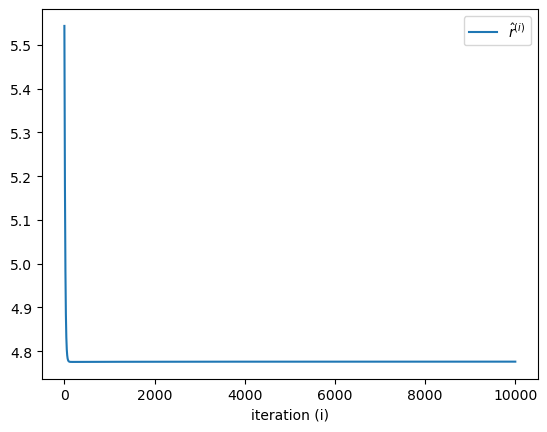

In [23]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

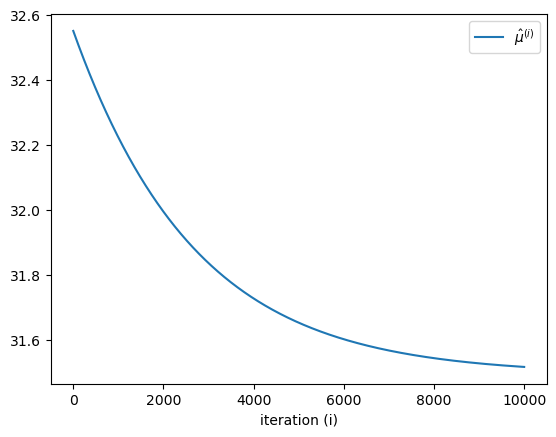

In [24]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

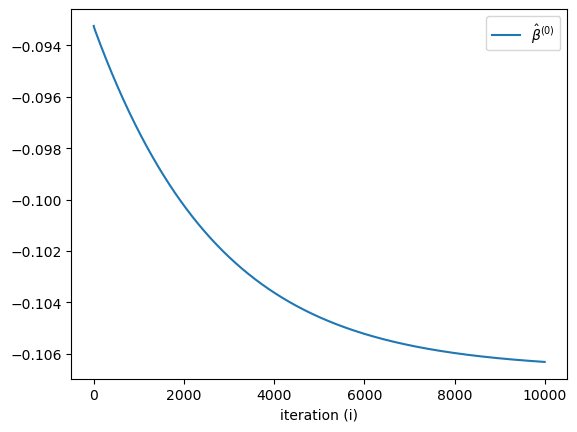

In [25]:
plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}$")
plt.xlabel("iteration (i)"); plt.legend()

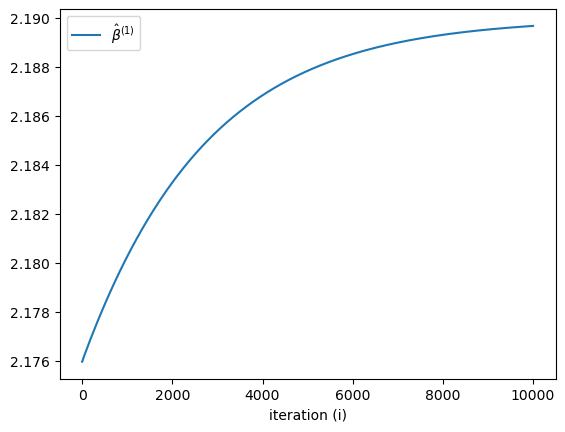

In [26]:
plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. EDA for nonparametric bootstrap

In [28]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [29]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [30]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [31]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [32]:
Pi_inv_ImG = Pi @ inv_ImG

In [33]:
EY = (Y_data @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2) * Pi_inv_ImG[:,0]

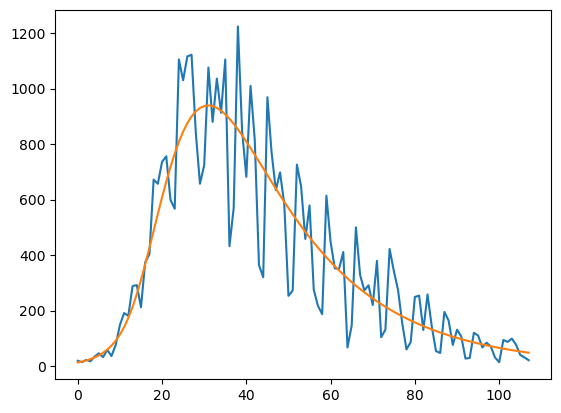

In [34]:
plt.plot(Y_data)
plt.plot(EY)

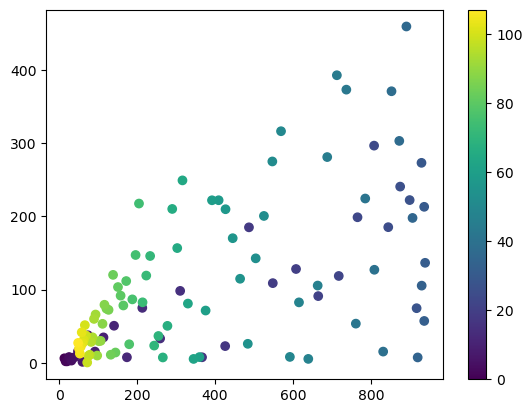

In [35]:
plt.scatter(EY, abs(Y_data-EY), c=np.arange(T))
plt.colorbar()

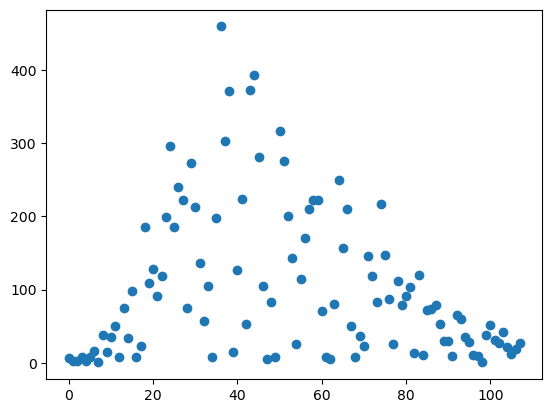

In [36]:
plt.scatter(np.arange(T), abs(Y_data - EY))

In [37]:
VYbT = np.zeros(T)
h = 4

In [38]:
# for t0 in np.arange(T):
#     w = np.exp(-((np.arange(T) - t0)/h)**2/2)
#     X = np.stack([np.full(T, 1), np.arange(T)]).T
#     y = (Y_data - EY)**2
#     b = la.solve(X.T @ np.diag(w) @ X, X.T @ np.diag(w) @ y)
#     VYbT[t0] = np.array([1, t0]) @ b

In [39]:
for t0 in np.arange(T):
    w = np.exp(-((np.arange(T) - t0)/h)**2/2)
    y = (Y_data - EY)**2
    VYbT[t0] = np.sum(w * y) / np.sum(w)

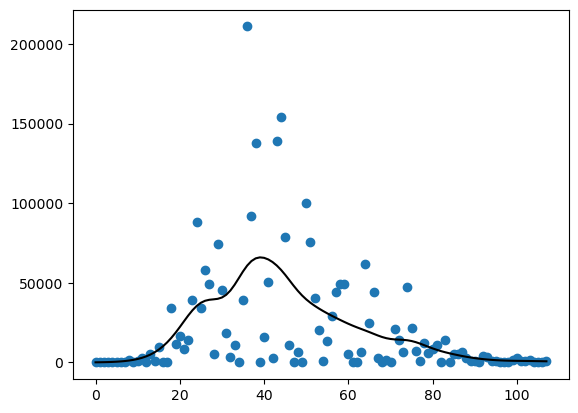

In [40]:
plt.scatter(np.arange(T), (Y_data - EY)**2)
plt.plot(VYbT, c='black')

In [41]:
eps_data = (Y_data-EY)/np.sqrt(VYbT)

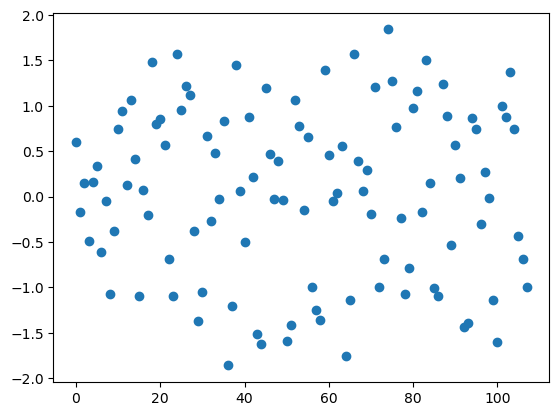

In [42]:
plt.scatter(np.arange(T), eps_data)

In [43]:
ar_order = 7
auto_eps = np.zeros(T)
for i in np.arange(ar_order+1):
    auto_eps[i] = np.mean(eps_data[i:] * eps_data[:T-i])

In [44]:
phi = la.solve(
    auto_eps[np.abs(np.arange(ar_order)[:,None] - np.arange(ar_order))],
    auto_eps[1:ar_order+1]
)

In [45]:
for i in np.arange(ar_order+1, T):
    auto_eps[i] = auto_eps[i-ar_order:i] @ phi[::-1]

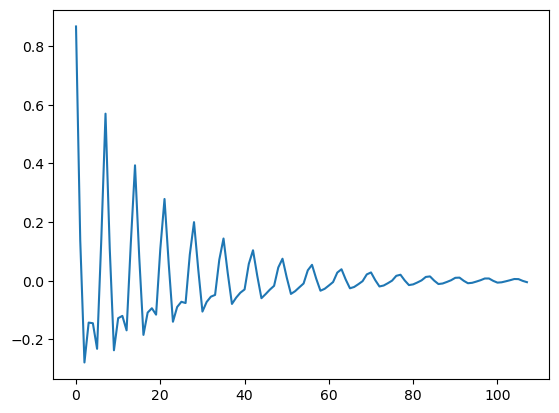

In [46]:
plt.plot(auto_eps)

In [47]:
Sigma_eps = auto_eps[np.abs(np.arange(T)[:,None] - np.arange(T))]

# 5. Nonparametric bootstrap

In [48]:
num_sim = 1000
n_iter = 10000

## simulation

In [49]:
eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)

In [50]:
Y_sim = np.around(np.maximum(EY + np.sqrt(VYbT)*eps_sim,0)).astype(int)

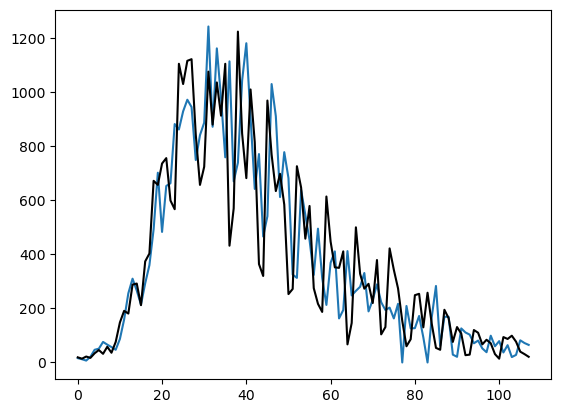

In [51]:
plt.plot(Y_sim)
plt.plot(Y_data, c='black')

In [130]:
rhs, mhs_0, bhs =\
    fit(Y_sim, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=n_iter, step_size=1)

Before EM, ll: -656.582533
1-th iteration finished, ll: -656.339494, lapse: 0.022sec.
2-th iteration finished, ll: -656.294208, lapse: 0.013sec.
3-th iteration finished, ll: -656.252288, lapse: 0.033sec.
4-th iteration finished, ll: -656.213565, lapse: 0.007sec.
5-th iteration finished, ll: -656.177873, lapse: 0.008sec.
6-th iteration finished, ll: -656.145043, lapse: 0.010sec.
7-th iteration finished, ll: -656.114908, lapse: 0.009sec.
8-th iteration finished, ll: -656.087305, lapse: 0.004sec.
9-th iteration finished, ll: -656.062073, lapse: 0.009sec.
10-th iteration finished, ll: -656.039054, lapse: 0.009sec.
11-th iteration finished, ll: -656.018095, lapse: 0.005sec.
12-th iteration finished, ll: -655.999049, lapse: 0.004sec.
13-th iteration finished, ll: -655.981774, lapse: 0.004sec.
14-th iteration finished, ll: -655.966134, lapse: 0.004sec.
15-th iteration finished, ll: -655.952001, lapse: 0.005sec.
16-th iteration finished, ll: -655.939251, lapse: 0.005sec.
17-th iteration finish

140-th iteration finished, ll: -655.833797, lapse: 0.006sec.
141-th iteration finished, ll: -655.833793, lapse: 0.007sec.
142-th iteration finished, ll: -655.833789, lapse: 0.009sec.
143-th iteration finished, ll: -655.833785, lapse: 0.013sec.
144-th iteration finished, ll: -655.833781, lapse: 0.005sec.
145-th iteration finished, ll: -655.833777, lapse: 0.009sec.
146-th iteration finished, ll: -655.833773, lapse: 0.007sec.
147-th iteration finished, ll: -655.833769, lapse: 0.015sec.
148-th iteration finished, ll: -655.833765, lapse: 0.004sec.
149-th iteration finished, ll: -655.833761, lapse: 0.007sec.
150-th iteration finished, ll: -655.833758, lapse: 0.004sec.
151-th iteration finished, ll: -655.833754, lapse: 0.004sec.
152-th iteration finished, ll: -655.833750, lapse: 0.005sec.
153-th iteration finished, ll: -655.833746, lapse: 0.010sec.
154-th iteration finished, ll: -655.833742, lapse: 0.010sec.
155-th iteration finished, ll: -655.833738, lapse: 0.005sec.
156-th iteration finishe

289-th iteration finished, ll: -655.833236, lapse: 0.013sec.
290-th iteration finished, ll: -655.833232, lapse: 0.014sec.
291-th iteration finished, ll: -655.833228, lapse: 0.010sec.
292-th iteration finished, ll: -655.833225, lapse: 0.009sec.
293-th iteration finished, ll: -655.833221, lapse: 0.010sec.
294-th iteration finished, ll: -655.833218, lapse: 0.007sec.
295-th iteration finished, ll: -655.833214, lapse: 0.017sec.
296-th iteration finished, ll: -655.833211, lapse: 0.009sec.
297-th iteration finished, ll: -655.833207, lapse: 0.008sec.
298-th iteration finished, ll: -655.833204, lapse: 0.007sec.
299-th iteration finished, ll: -655.833200, lapse: 0.006sec.
300-th iteration finished, ll: -655.833196, lapse: 0.004sec.
301-th iteration finished, ll: -655.833193, lapse: 0.009sec.
302-th iteration finished, ll: -655.833189, lapse: 0.005sec.
303-th iteration finished, ll: -655.833186, lapse: 0.005sec.
304-th iteration finished, ll: -655.833182, lapse: 0.005sec.
305-th iteration finishe

438-th iteration finished, ll: -655.832730, lapse: 0.018sec.
439-th iteration finished, ll: -655.832727, lapse: 0.009sec.
440-th iteration finished, ll: -655.832724, lapse: 0.012sec.
441-th iteration finished, ll: -655.832720, lapse: 0.013sec.
442-th iteration finished, ll: -655.832717, lapse: 0.007sec.
443-th iteration finished, ll: -655.832714, lapse: 0.006sec.
444-th iteration finished, ll: -655.832711, lapse: 0.004sec.
445-th iteration finished, ll: -655.832708, lapse: 0.006sec.
446-th iteration finished, ll: -655.832704, lapse: 0.008sec.
447-th iteration finished, ll: -655.832701, lapse: 0.004sec.
448-th iteration finished, ll: -655.832698, lapse: 0.004sec.
449-th iteration finished, ll: -655.832695, lapse: 0.009sec.
450-th iteration finished, ll: -655.832692, lapse: 0.007sec.
451-th iteration finished, ll: -655.832688, lapse: 0.005sec.
452-th iteration finished, ll: -655.832685, lapse: 0.008sec.
453-th iteration finished, ll: -655.832682, lapse: 0.011sec.
454-th iteration finishe

582-th iteration finished, ll: -655.832290, lapse: 0.010sec.
583-th iteration finished, ll: -655.832287, lapse: 0.010sec.
584-th iteration finished, ll: -655.832284, lapse: 0.012sec.
585-th iteration finished, ll: -655.832281, lapse: 0.010sec.
586-th iteration finished, ll: -655.832278, lapse: 0.008sec.
587-th iteration finished, ll: -655.832275, lapse: 0.011sec.
588-th iteration finished, ll: -655.832272, lapse: 0.010sec.
589-th iteration finished, ll: -655.832269, lapse: 0.010sec.
590-th iteration finished, ll: -655.832267, lapse: 0.005sec.
591-th iteration finished, ll: -655.832264, lapse: 0.006sec.
592-th iteration finished, ll: -655.832261, lapse: 0.006sec.
593-th iteration finished, ll: -655.832258, lapse: 0.009sec.
594-th iteration finished, ll: -655.832255, lapse: 0.013sec.
595-th iteration finished, ll: -655.832252, lapse: 0.008sec.
596-th iteration finished, ll: -655.832249, lapse: 0.008sec.
597-th iteration finished, ll: -655.832246, lapse: 0.005sec.
598-th iteration finishe

726-th iteration finished, ll: -655.831892, lapse: 0.017sec.
727-th iteration finished, ll: -655.831890, lapse: 0.012sec.
728-th iteration finished, ll: -655.831887, lapse: 0.014sec.
729-th iteration finished, ll: -655.831884, lapse: 0.007sec.
730-th iteration finished, ll: -655.831882, lapse: 0.007sec.
731-th iteration finished, ll: -655.831879, lapse: 0.006sec.
732-th iteration finished, ll: -655.831877, lapse: 0.005sec.
733-th iteration finished, ll: -655.831874, lapse: 0.004sec.
734-th iteration finished, ll: -655.831871, lapse: 0.005sec.
735-th iteration finished, ll: -655.831869, lapse: 0.008sec.
736-th iteration finished, ll: -655.831866, lapse: 0.007sec.
737-th iteration finished, ll: -655.831864, lapse: 0.009sec.
738-th iteration finished, ll: -655.831861, lapse: 0.004sec.
739-th iteration finished, ll: -655.831858, lapse: 0.004sec.
740-th iteration finished, ll: -655.831856, lapse: 0.004sec.
741-th iteration finished, ll: -655.831853, lapse: 0.004sec.
742-th iteration finishe

870-th iteration finished, ll: -655.831534, lapse: 0.008sec.
871-th iteration finished, ll: -655.831531, lapse: 0.017sec.
872-th iteration finished, ll: -655.831529, lapse: 0.009sec.
873-th iteration finished, ll: -655.831527, lapse: 0.005sec.
874-th iteration finished, ll: -655.831524, lapse: 0.009sec.
875-th iteration finished, ll: -655.831522, lapse: 0.004sec.
876-th iteration finished, ll: -655.831520, lapse: 0.004sec.
877-th iteration finished, ll: -655.831517, lapse: 0.004sec.
878-th iteration finished, ll: -655.831515, lapse: 0.004sec.
879-th iteration finished, ll: -655.831513, lapse: 0.006sec.
880-th iteration finished, ll: -655.831510, lapse: 0.009sec.
881-th iteration finished, ll: -655.831508, lapse: 0.006sec.
882-th iteration finished, ll: -655.831506, lapse: 0.006sec.
883-th iteration finished, ll: -655.831503, lapse: 0.007sec.
884-th iteration finished, ll: -655.831501, lapse: 0.004sec.
885-th iteration finished, ll: -655.831498, lapse: 0.004sec.
886-th iteration finishe

1007-th iteration finished, ll: -655.831225, lapse: 0.005sec.
1008-th iteration finished, ll: -655.831223, lapse: 0.016sec.
1009-th iteration finished, ll: -655.831221, lapse: 0.005sec.
1010-th iteration finished, ll: -655.831219, lapse: 0.006sec.
1011-th iteration finished, ll: -655.831217, lapse: 0.017sec.
1012-th iteration finished, ll: -655.831215, lapse: 0.006sec.
1013-th iteration finished, ll: -655.831213, lapse: 0.010sec.
1014-th iteration finished, ll: -655.831210, lapse: 0.004sec.
1015-th iteration finished, ll: -655.831208, lapse: 0.009sec.
1016-th iteration finished, ll: -655.831206, lapse: 0.005sec.
1017-th iteration finished, ll: -655.831204, lapse: 0.007sec.
1018-th iteration finished, ll: -655.831202, lapse: 0.005sec.
1019-th iteration finished, ll: -655.831200, lapse: 0.009sec.
1020-th iteration finished, ll: -655.831198, lapse: 0.009sec.
1021-th iteration finished, ll: -655.831196, lapse: 0.010sec.
1022-th iteration finished, ll: -655.831193, lapse: 0.008sec.
1023-th 

1140-th iteration finished, ll: -655.830954, lapse: 0.010sec.
1141-th iteration finished, ll: -655.830952, lapse: 0.018sec.
1142-th iteration finished, ll: -655.830950, lapse: 0.012sec.
1143-th iteration finished, ll: -655.830948, lapse: 0.005sec.
1144-th iteration finished, ll: -655.830946, lapse: 0.012sec.
1145-th iteration finished, ll: -655.830944, lapse: 0.006sec.
1146-th iteration finished, ll: -655.830942, lapse: 0.009sec.
1147-th iteration finished, ll: -655.830940, lapse: 0.005sec.
1148-th iteration finished, ll: -655.830938, lapse: 0.009sec.
1149-th iteration finished, ll: -655.830936, lapse: 0.012sec.
1150-th iteration finished, ll: -655.830934, lapse: 0.004sec.
1151-th iteration finished, ll: -655.830933, lapse: 0.006sec.
1152-th iteration finished, ll: -655.830931, lapse: 0.004sec.
1153-th iteration finished, ll: -655.830929, lapse: 0.009sec.
1154-th iteration finished, ll: -655.830927, lapse: 0.005sec.
1155-th iteration finished, ll: -655.830925, lapse: 0.004sec.
1156-th 

1292-th iteration finished, ll: -655.830674, lapse: 0.012sec.
1293-th iteration finished, ll: -655.830672, lapse: 0.016sec.
1294-th iteration finished, ll: -655.830670, lapse: 0.010sec.
1295-th iteration finished, ll: -655.830669, lapse: 0.007sec.
1296-th iteration finished, ll: -655.830667, lapse: 0.011sec.
1297-th iteration finished, ll: -655.830665, lapse: 0.009sec.
1298-th iteration finished, ll: -655.830663, lapse: 0.012sec.
1299-th iteration finished, ll: -655.830662, lapse: 0.013sec.
1300-th iteration finished, ll: -655.830660, lapse: 0.006sec.
1301-th iteration finished, ll: -655.830658, lapse: 0.004sec.
1302-th iteration finished, ll: -655.830656, lapse: 0.007sec.
1303-th iteration finished, ll: -655.830655, lapse: 0.009sec.
1304-th iteration finished, ll: -655.830653, lapse: 0.006sec.
1305-th iteration finished, ll: -655.830651, lapse: 0.005sec.
1306-th iteration finished, ll: -655.830650, lapse: 0.006sec.
1307-th iteration finished, ll: -655.830648, lapse: 0.011sec.
1308-th 

1447-th iteration finished, ll: -655.830418, lapse: 0.008sec.
1448-th iteration finished, ll: -655.830417, lapse: 0.012sec.
1449-th iteration finished, ll: -655.830415, lapse: 0.008sec.
1450-th iteration finished, ll: -655.830414, lapse: 0.010sec.
1451-th iteration finished, ll: -655.830412, lapse: 0.006sec.
1452-th iteration finished, ll: -655.830411, lapse: 0.006sec.
1453-th iteration finished, ll: -655.830409, lapse: 0.010sec.
1454-th iteration finished, ll: -655.830408, lapse: 0.009sec.
1455-th iteration finished, ll: -655.830406, lapse: 0.005sec.
1456-th iteration finished, ll: -655.830404, lapse: 0.008sec.
1457-th iteration finished, ll: -655.830403, lapse: 0.007sec.
1458-th iteration finished, ll: -655.830401, lapse: 0.004sec.
1459-th iteration finished, ll: -655.830400, lapse: 0.004sec.
1460-th iteration finished, ll: -655.830398, lapse: 0.004sec.
1461-th iteration finished, ll: -655.830397, lapse: 0.006sec.
1462-th iteration finished, ll: -655.830395, lapse: 0.006sec.
1463-th 

1612-th iteration finished, ll: -655.830176, lapse: 0.007sec.
1613-th iteration finished, ll: -655.830175, lapse: 0.015sec.
1614-th iteration finished, ll: -655.830174, lapse: 0.009sec.
1615-th iteration finished, ll: -655.830172, lapse: 0.008sec.
1616-th iteration finished, ll: -655.830171, lapse: 0.012sec.
1617-th iteration finished, ll: -655.830170, lapse: 0.005sec.
1618-th iteration finished, ll: -655.830168, lapse: 0.007sec.
1619-th iteration finished, ll: -655.830167, lapse: 0.009sec.
1620-th iteration finished, ll: -655.830165, lapse: 0.005sec.
1621-th iteration finished, ll: -655.830164, lapse: 0.004sec.
1622-th iteration finished, ll: -655.830163, lapse: 0.006sec.
1623-th iteration finished, ll: -655.830161, lapse: 0.008sec.
1624-th iteration finished, ll: -655.830160, lapse: 0.004sec.
1625-th iteration finished, ll: -655.830159, lapse: 0.004sec.
1626-th iteration finished, ll: -655.830157, lapse: 0.004sec.
1627-th iteration finished, ll: -655.830156, lapse: 0.007sec.
1628-th 

1780-th iteration finished, ll: -655.829958, lapse: 0.009sec.
1781-th iteration finished, ll: -655.829957, lapse: 0.010sec.
1782-th iteration finished, ll: -655.829956, lapse: 0.006sec.
1783-th iteration finished, ll: -655.829955, lapse: 0.004sec.
1784-th iteration finished, ll: -655.829953, lapse: 0.012sec.
1785-th iteration finished, ll: -655.829952, lapse: 0.009sec.
1786-th iteration finished, ll: -655.829951, lapse: 0.006sec.
1787-th iteration finished, ll: -655.829950, lapse: 0.004sec.
1788-th iteration finished, ll: -655.829949, lapse: 0.004sec.
1789-th iteration finished, ll: -655.829947, lapse: 0.004sec.
1790-th iteration finished, ll: -655.829946, lapse: 0.005sec.
1791-th iteration finished, ll: -655.829945, lapse: 0.006sec.
1792-th iteration finished, ll: -655.829944, lapse: 0.006sec.
1793-th iteration finished, ll: -655.829943, lapse: 0.004sec.
1794-th iteration finished, ll: -655.829941, lapse: 0.005sec.
1795-th iteration finished, ll: -655.829940, lapse: 0.011sec.
1796-th 

1947-th iteration finished, ll: -655.829767, lapse: 0.009sec.
1948-th iteration finished, ll: -655.829766, lapse: 0.014sec.
1949-th iteration finished, ll: -655.829764, lapse: 0.004sec.
1950-th iteration finished, ll: -655.829763, lapse: 0.005sec.
1951-th iteration finished, ll: -655.829762, lapse: 0.008sec.
1952-th iteration finished, ll: -655.829761, lapse: 0.007sec.
1953-th iteration finished, ll: -655.829760, lapse: 0.009sec.
1954-th iteration finished, ll: -655.829759, lapse: 0.010sec.
1955-th iteration finished, ll: -655.829758, lapse: 0.005sec.
1956-th iteration finished, ll: -655.829757, lapse: 0.006sec.
1957-th iteration finished, ll: -655.829756, lapse: 0.007sec.
1958-th iteration finished, ll: -655.829755, lapse: 0.005sec.
1959-th iteration finished, ll: -655.829754, lapse: 0.004sec.
1960-th iteration finished, ll: -655.829753, lapse: 0.009sec.
1961-th iteration finished, ll: -655.829752, lapse: 0.006sec.
1962-th iteration finished, ll: -655.829751, lapse: 0.006sec.
1963-th 

2115-th iteration finished, ll: -655.829596, lapse: 0.017sec.
2116-th iteration finished, ll: -655.829595, lapse: 0.008sec.
2117-th iteration finished, ll: -655.829594, lapse: 0.009sec.
2118-th iteration finished, ll: -655.829593, lapse: 0.007sec.
2119-th iteration finished, ll: -655.829592, lapse: 0.008sec.
2120-th iteration finished, ll: -655.829591, lapse: 0.005sec.
2121-th iteration finished, ll: -655.829590, lapse: 0.007sec.
2122-th iteration finished, ll: -655.829589, lapse: 0.004sec.
2123-th iteration finished, ll: -655.829589, lapse: 0.004sec.
2124-th iteration finished, ll: -655.829588, lapse: 0.008sec.
2125-th iteration finished, ll: -655.829587, lapse: 0.008sec.
2126-th iteration finished, ll: -655.829586, lapse: 0.008sec.
2127-th iteration finished, ll: -655.829585, lapse: 0.005sec.
2128-th iteration finished, ll: -655.829584, lapse: 0.009sec.
2129-th iteration finished, ll: -655.829583, lapse: 0.006sec.
2130-th iteration finished, ll: -655.829582, lapse: 0.004sec.
2131-th 

2277-th iteration finished, ll: -655.829451, lapse: 0.007sec.
2278-th iteration finished, ll: -655.829450, lapse: 0.016sec.
2279-th iteration finished, ll: -655.829449, lapse: 0.012sec.
2280-th iteration finished, ll: -655.829448, lapse: 0.005sec.
2281-th iteration finished, ll: -655.829447, lapse: 0.007sec.
2282-th iteration finished, ll: -655.829446, lapse: 0.004sec.
2283-th iteration finished, ll: -655.829446, lapse: 0.005sec.
2284-th iteration finished, ll: -655.829445, lapse: 0.010sec.
2285-th iteration finished, ll: -655.829444, lapse: 0.004sec.
2286-th iteration finished, ll: -655.829443, lapse: 0.006sec.
2287-th iteration finished, ll: -655.829442, lapse: 0.004sec.
2288-th iteration finished, ll: -655.829441, lapse: 0.004sec.
2289-th iteration finished, ll: -655.829441, lapse: 0.006sec.
2290-th iteration finished, ll: -655.829440, lapse: 0.004sec.
2291-th iteration finished, ll: -655.829439, lapse: 0.005sec.
2292-th iteration finished, ll: -655.829438, lapse: 0.004sec.
2293-th 

2416-th iteration finished, ll: -655.829339, lapse: 0.009sec.
2417-th iteration finished, ll: -655.829338, lapse: 0.017sec.
2418-th iteration finished, ll: -655.829337, lapse: 0.011sec.
2419-th iteration finished, ll: -655.829337, lapse: 0.007sec.
2420-th iteration finished, ll: -655.829336, lapse: 0.008sec.
2421-th iteration finished, ll: -655.829335, lapse: 0.005sec.
2422-th iteration finished, ll: -655.829334, lapse: 0.004sec.
2423-th iteration finished, ll: -655.829334, lapse: 0.004sec.
2424-th iteration finished, ll: -655.829333, lapse: 0.009sec.
2425-th iteration finished, ll: -655.829332, lapse: 0.007sec.
2426-th iteration finished, ll: -655.829331, lapse: 0.004sec.
2427-th iteration finished, ll: -655.829331, lapse: 0.006sec.
2428-th iteration finished, ll: -655.829330, lapse: 0.012sec.
2429-th iteration finished, ll: -655.829329, lapse: 0.009sec.
2430-th iteration finished, ll: -655.829328, lapse: 0.004sec.
2431-th iteration finished, ll: -655.829328, lapse: 0.008sec.
2432-th 

2578-th iteration finished, ll: -655.829223, lapse: 0.008sec.
2579-th iteration finished, ll: -655.829222, lapse: 0.009sec.
2580-th iteration finished, ll: -655.829221, lapse: 0.012sec.
2581-th iteration finished, ll: -655.829221, lapse: 0.009sec.
2582-th iteration finished, ll: -655.829220, lapse: 0.008sec.
2583-th iteration finished, ll: -655.829219, lapse: 0.009sec.
2584-th iteration finished, ll: -655.829219, lapse: 0.005sec.
2585-th iteration finished, ll: -655.829218, lapse: 0.005sec.
2586-th iteration finished, ll: -655.829217, lapse: 0.006sec.
2587-th iteration finished, ll: -655.829217, lapse: 0.007sec.
2588-th iteration finished, ll: -655.829216, lapse: 0.006sec.
2589-th iteration finished, ll: -655.829215, lapse: 0.007sec.
2590-th iteration finished, ll: -655.829215, lapse: 0.007sec.
2591-th iteration finished, ll: -655.829214, lapse: 0.006sec.
2592-th iteration finished, ll: -655.829213, lapse: 0.010sec.
2593-th iteration finished, ll: -655.829213, lapse: 0.005sec.
2594-th 

2739-th iteration finished, ll: -655.829120, lapse: 0.010sec.
2740-th iteration finished, ll: -655.829119, lapse: 0.014sec.
2741-th iteration finished, ll: -655.829119, lapse: 0.008sec.
2742-th iteration finished, ll: -655.829118, lapse: 0.008sec.
2743-th iteration finished, ll: -655.829118, lapse: 0.006sec.
2744-th iteration finished, ll: -655.829117, lapse: 0.007sec.
2745-th iteration finished, ll: -655.829117, lapse: 0.004sec.
2746-th iteration finished, ll: -655.829116, lapse: 0.004sec.
2747-th iteration finished, ll: -655.829115, lapse: 0.006sec.
2748-th iteration finished, ll: -655.829115, lapse: 0.007sec.
2749-th iteration finished, ll: -655.829114, lapse: 0.006sec.
2750-th iteration finished, ll: -655.829114, lapse: 0.006sec.
2751-th iteration finished, ll: -655.829113, lapse: 0.008sec.
2752-th iteration finished, ll: -655.829112, lapse: 0.007sec.
2753-th iteration finished, ll: -655.829112, lapse: 0.008sec.
2754-th iteration finished, ll: -655.829111, lapse: 0.006sec.
2755-th 

2900-th iteration finished, ll: -655.829029, lapse: 0.009sec.
2901-th iteration finished, ll: -655.829029, lapse: 0.009sec.
2902-th iteration finished, ll: -655.829028, lapse: 0.016sec.
2903-th iteration finished, ll: -655.829028, lapse: 0.010sec.
2904-th iteration finished, ll: -655.829027, lapse: 0.008sec.
2905-th iteration finished, ll: -655.829027, lapse: 0.006sec.
2906-th iteration finished, ll: -655.829026, lapse: 0.008sec.
2907-th iteration finished, ll: -655.829025, lapse: 0.004sec.
2908-th iteration finished, ll: -655.829025, lapse: 0.005sec.
2909-th iteration finished, ll: -655.829024, lapse: 0.007sec.
2910-th iteration finished, ll: -655.829024, lapse: 0.004sec.
2911-th iteration finished, ll: -655.829023, lapse: 0.006sec.
2912-th iteration finished, ll: -655.829023, lapse: 0.008sec.
2913-th iteration finished, ll: -655.829022, lapse: 0.007sec.
2914-th iteration finished, ll: -655.829022, lapse: 0.007sec.
2915-th iteration finished, ll: -655.829021, lapse: 0.004sec.
2916-th 

3052-th iteration finished, ll: -655.828953, lapse: 0.017sec.
3053-th iteration finished, ll: -655.828952, lapse: 0.012sec.
3054-th iteration finished, ll: -655.828952, lapse: 0.004sec.
3055-th iteration finished, ll: -655.828951, lapse: 0.012sec.
3056-th iteration finished, ll: -655.828951, lapse: 0.007sec.
3057-th iteration finished, ll: -655.828950, lapse: 0.006sec.
3058-th iteration finished, ll: -655.828950, lapse: 0.010sec.
3059-th iteration finished, ll: -655.828950, lapse: 0.005sec.
3060-th iteration finished, ll: -655.828949, lapse: 0.007sec.
3061-th iteration finished, ll: -655.828949, lapse: 0.006sec.
3062-th iteration finished, ll: -655.828948, lapse: 0.020sec.
3063-th iteration finished, ll: -655.828948, lapse: 0.007sec.
3064-th iteration finished, ll: -655.828947, lapse: 0.005sec.
3065-th iteration finished, ll: -655.828947, lapse: 0.004sec.
3066-th iteration finished, ll: -655.828946, lapse: 0.005sec.
3067-th iteration finished, ll: -655.828946, lapse: 0.008sec.
3068-th 

3209-th iteration finished, ll: -655.828883, lapse: 0.005sec.
3210-th iteration finished, ll: -655.828882, lapse: 0.019sec.
3211-th iteration finished, ll: -655.828882, lapse: 0.007sec.
3212-th iteration finished, ll: -655.828881, lapse: 0.011sec.
3213-th iteration finished, ll: -655.828881, lapse: 0.009sec.
3214-th iteration finished, ll: -655.828880, lapse: 0.004sec.
3215-th iteration finished, ll: -655.828880, lapse: 0.004sec.
3216-th iteration finished, ll: -655.828880, lapse: 0.007sec.
3217-th iteration finished, ll: -655.828879, lapse: 0.006sec.
3218-th iteration finished, ll: -655.828879, lapse: 0.008sec.
3219-th iteration finished, ll: -655.828878, lapse: 0.005sec.
3220-th iteration finished, ll: -655.828878, lapse: 0.004sec.
3221-th iteration finished, ll: -655.828878, lapse: 0.004sec.
3222-th iteration finished, ll: -655.828877, lapse: 0.004sec.
3223-th iteration finished, ll: -655.828877, lapse: 0.004sec.
3224-th iteration finished, ll: -655.828876, lapse: 0.007sec.
3225-th 

3342-th iteration finished, ll: -655.828829, lapse: 0.006sec.
3343-th iteration finished, ll: -655.828829, lapse: 0.015sec.
3344-th iteration finished, ll: -655.828828, lapse: 0.006sec.
3345-th iteration finished, ll: -655.828828, lapse: 0.007sec.
3346-th iteration finished, ll: -655.828828, lapse: 0.007sec.
3347-th iteration finished, ll: -655.828827, lapse: 0.004sec.
3348-th iteration finished, ll: -655.828827, lapse: 0.004sec.
3349-th iteration finished, ll: -655.828827, lapse: 0.005sec.
3350-th iteration finished, ll: -655.828826, lapse: 0.008sec.
3351-th iteration finished, ll: -655.828826, lapse: 0.004sec.
3352-th iteration finished, ll: -655.828825, lapse: 0.005sec.
3353-th iteration finished, ll: -655.828825, lapse: 0.008sec.
3354-th iteration finished, ll: -655.828825, lapse: 0.005sec.
3355-th iteration finished, ll: -655.828824, lapse: 0.004sec.
3356-th iteration finished, ll: -655.828824, lapse: 0.006sec.
3357-th iteration finished, ll: -655.828824, lapse: 0.009sec.
3358-th 

3479-th iteration finished, ll: -655.828780, lapse: 0.008sec.
3480-th iteration finished, ll: -655.828779, lapse: 0.014sec.
3481-th iteration finished, ll: -655.828779, lapse: 0.006sec.
3482-th iteration finished, ll: -655.828779, lapse: 0.012sec.
3483-th iteration finished, ll: -655.828778, lapse: 0.008sec.
3484-th iteration finished, ll: -655.828778, lapse: 0.004sec.
3485-th iteration finished, ll: -655.828778, lapse: 0.005sec.
3486-th iteration finished, ll: -655.828777, lapse: 0.004sec.
3487-th iteration finished, ll: -655.828777, lapse: 0.005sec.
3488-th iteration finished, ll: -655.828777, lapse: 0.005sec.
3489-th iteration finished, ll: -655.828776, lapse: 0.009sec.
3490-th iteration finished, ll: -655.828776, lapse: 0.007sec.
3491-th iteration finished, ll: -655.828776, lapse: 0.006sec.
3492-th iteration finished, ll: -655.828775, lapse: 0.006sec.
3493-th iteration finished, ll: -655.828775, lapse: 0.009sec.
3494-th iteration finished, ll: -655.828774, lapse: 0.005sec.
3495-th 

3615-th iteration finished, ll: -655.828735, lapse: 0.009sec.
3616-th iteration finished, ll: -655.828735, lapse: 0.013sec.
3617-th iteration finished, ll: -655.828735, lapse: 0.004sec.
3618-th iteration finished, ll: -655.828734, lapse: 0.007sec.
3619-th iteration finished, ll: -655.828734, lapse: 0.004sec.
3620-th iteration finished, ll: -655.828734, lapse: 0.006sec.
3621-th iteration finished, ll: -655.828733, lapse: 0.004sec.
3622-th iteration finished, ll: -655.828733, lapse: 0.004sec.
3623-th iteration finished, ll: -655.828733, lapse: 0.005sec.
3624-th iteration finished, ll: -655.828732, lapse: 0.005sec.
3625-th iteration finished, ll: -655.828732, lapse: 0.004sec.
3626-th iteration finished, ll: -655.828732, lapse: 0.004sec.
3627-th iteration finished, ll: -655.828731, lapse: 0.005sec.
3628-th iteration finished, ll: -655.828731, lapse: 0.004sec.
3629-th iteration finished, ll: -655.828731, lapse: 0.004sec.
3630-th iteration finished, ll: -655.828731, lapse: 0.004sec.
3631-th 

3776-th iteration finished, ll: -655.828688, lapse: 0.005sec.
3777-th iteration finished, ll: -655.828688, lapse: 0.015sec.
3778-th iteration finished, ll: -655.828688, lapse: 0.004sec.
3779-th iteration finished, ll: -655.828687, lapse: 0.010sec.
3780-th iteration finished, ll: -655.828687, lapse: 0.012sec.
3781-th iteration finished, ll: -655.828687, lapse: 0.009sec.
3782-th iteration finished, ll: -655.828686, lapse: 0.005sec.
3783-th iteration finished, ll: -655.828686, lapse: 0.008sec.
3784-th iteration finished, ll: -655.828686, lapse: 0.009sec.
3785-th iteration finished, ll: -655.828686, lapse: 0.007sec.
3786-th iteration finished, ll: -655.828685, lapse: 0.011sec.
3787-th iteration finished, ll: -655.828685, lapse: 0.012sec.
3788-th iteration finished, ll: -655.828685, lapse: 0.006sec.
3789-th iteration finished, ll: -655.828685, lapse: 0.009sec.
3790-th iteration finished, ll: -655.828684, lapse: 0.008sec.
3791-th iteration finished, ll: -655.828684, lapse: 0.005sec.
3792-th 

3940-th iteration finished, ll: -655.828646, lapse: 0.014sec.
3941-th iteration finished, ll: -655.828645, lapse: 0.010sec.
3942-th iteration finished, ll: -655.828645, lapse: 0.006sec.
3943-th iteration finished, ll: -655.828645, lapse: 0.008sec.
3944-th iteration finished, ll: -655.828645, lapse: 0.005sec.
3945-th iteration finished, ll: -655.828644, lapse: 0.004sec.
3946-th iteration finished, ll: -655.828644, lapse: 0.006sec.
3947-th iteration finished, ll: -655.828644, lapse: 0.005sec.
3948-th iteration finished, ll: -655.828644, lapse: 0.004sec.
3949-th iteration finished, ll: -655.828644, lapse: 0.004sec.
3950-th iteration finished, ll: -655.828643, lapse: 0.009sec.
3951-th iteration finished, ll: -655.828643, lapse: 0.005sec.
3952-th iteration finished, ll: -655.828643, lapse: 0.009sec.
3953-th iteration finished, ll: -655.828643, lapse: 0.011sec.
3954-th iteration finished, ll: -655.828642, lapse: 0.007sec.
3955-th iteration finished, ll: -655.828642, lapse: 0.005sec.
3956-th 

4073-th iteration finished, ll: -655.828615, lapse: 0.008sec.
4074-th iteration finished, ll: -655.828615, lapse: 0.009sec.
4075-th iteration finished, ll: -655.828615, lapse: 0.005sec.
4076-th iteration finished, ll: -655.828614, lapse: 0.019sec.
4077-th iteration finished, ll: -655.828614, lapse: 0.008sec.
4078-th iteration finished, ll: -655.828614, lapse: 0.009sec.
4079-th iteration finished, ll: -655.828614, lapse: 0.007sec.
4080-th iteration finished, ll: -655.828613, lapse: 0.006sec.
4081-th iteration finished, ll: -655.828613, lapse: 0.004sec.
4082-th iteration finished, ll: -655.828613, lapse: 0.005sec.
4083-th iteration finished, ll: -655.828613, lapse: 0.007sec.
4084-th iteration finished, ll: -655.828613, lapse: 0.006sec.
4085-th iteration finished, ll: -655.828612, lapse: 0.005sec.
4086-th iteration finished, ll: -655.828612, lapse: 0.005sec.
4087-th iteration finished, ll: -655.828612, lapse: 0.004sec.
4088-th iteration finished, ll: -655.828612, lapse: 0.005sec.
4089-th 

4208-th iteration finished, ll: -655.828587, lapse: 0.010sec.
4209-th iteration finished, ll: -655.828587, lapse: 0.018sec.
4210-th iteration finished, ll: -655.828586, lapse: 0.006sec.
4211-th iteration finished, ll: -655.828586, lapse: 0.007sec.
4212-th iteration finished, ll: -655.828586, lapse: 0.007sec.
4213-th iteration finished, ll: -655.828586, lapse: 0.005sec.
4214-th iteration finished, ll: -655.828586, lapse: 0.007sec.
4215-th iteration finished, ll: -655.828585, lapse: 0.004sec.
4216-th iteration finished, ll: -655.828585, lapse: 0.009sec.
4217-th iteration finished, ll: -655.828585, lapse: 0.006sec.
4218-th iteration finished, ll: -655.828585, lapse: 0.006sec.
4219-th iteration finished, ll: -655.828585, lapse: 0.008sec.
4220-th iteration finished, ll: -655.828584, lapse: 0.007sec.
4221-th iteration finished, ll: -655.828584, lapse: 0.006sec.
4222-th iteration finished, ll: -655.828584, lapse: 0.004sec.
4223-th iteration finished, ll: -655.828584, lapse: 0.005sec.
4224-th 

4372-th iteration finished, ll: -655.828556, lapse: 0.008sec.
4373-th iteration finished, ll: -655.828556, lapse: 0.010sec.
4374-th iteration finished, ll: -655.828556, lapse: 0.007sec.
4375-th iteration finished, ll: -655.828556, lapse: 0.004sec.
4376-th iteration finished, ll: -655.828556, lapse: 0.009sec.
4377-th iteration finished, ll: -655.828555, lapse: 0.005sec.
4378-th iteration finished, ll: -655.828555, lapse: 0.004sec.
4379-th iteration finished, ll: -655.828555, lapse: 0.005sec.
4380-th iteration finished, ll: -655.828555, lapse: 0.007sec.
4381-th iteration finished, ll: -655.828555, lapse: 0.008sec.
4382-th iteration finished, ll: -655.828555, lapse: 0.004sec.
4383-th iteration finished, ll: -655.828554, lapse: 0.007sec.
4384-th iteration finished, ll: -655.828554, lapse: 0.006sec.
4385-th iteration finished, ll: -655.828554, lapse: 0.008sec.
4386-th iteration finished, ll: -655.828554, lapse: 0.007sec.
4387-th iteration finished, ll: -655.828554, lapse: 0.006sec.
4388-th 

4536-th iteration finished, ll: -655.828529, lapse: 0.007sec.
4537-th iteration finished, ll: -655.828529, lapse: 0.009sec.
4538-th iteration finished, ll: -655.828529, lapse: 0.014sec.
4539-th iteration finished, ll: -655.828529, lapse: 0.005sec.
4540-th iteration finished, ll: -655.828529, lapse: 0.005sec.
4541-th iteration finished, ll: -655.828529, lapse: 0.008sec.
4542-th iteration finished, ll: -655.828528, lapse: 0.007sec.
4543-th iteration finished, ll: -655.828528, lapse: 0.007sec.
4544-th iteration finished, ll: -655.828528, lapse: 0.004sec.
4545-th iteration finished, ll: -655.828528, lapse: 0.004sec.
4546-th iteration finished, ll: -655.828528, lapse: 0.004sec.
4547-th iteration finished, ll: -655.828528, lapse: 0.004sec.
4548-th iteration finished, ll: -655.828527, lapse: 0.004sec.
4549-th iteration finished, ll: -655.828527, lapse: 0.007sec.
4550-th iteration finished, ll: -655.828527, lapse: 0.005sec.
4551-th iteration finished, ll: -655.828527, lapse: 0.009sec.
4552-th 

4696-th iteration finished, ll: -655.828506, lapse: 0.014sec.
4697-th iteration finished, ll: -655.828506, lapse: 0.006sec.
4698-th iteration finished, ll: -655.828506, lapse: 0.009sec.
4699-th iteration finished, ll: -655.828506, lapse: 0.011sec.
4700-th iteration finished, ll: -655.828506, lapse: 0.010sec.
4701-th iteration finished, ll: -655.828505, lapse: 0.006sec.
4702-th iteration finished, ll: -655.828505, lapse: 0.007sec.
4703-th iteration finished, ll: -655.828505, lapse: 0.007sec.
4704-th iteration finished, ll: -655.828505, lapse: 0.004sec.
4705-th iteration finished, ll: -655.828505, lapse: 0.008sec.
4706-th iteration finished, ll: -655.828505, lapse: 0.010sec.
4707-th iteration finished, ll: -655.828505, lapse: 0.005sec.
4708-th iteration finished, ll: -655.828504, lapse: 0.006sec.
4709-th iteration finished, ll: -655.828504, lapse: 0.007sec.
4710-th iteration finished, ll: -655.828504, lapse: 0.007sec.
4711-th iteration finished, ll: -655.828504, lapse: 0.004sec.
4712-th 

4845-th iteration finished, ll: -655.828487, lapse: 0.016sec.
4846-th iteration finished, ll: -655.828487, lapse: 0.010sec.
4847-th iteration finished, ll: -655.828487, lapse: 0.005sec.
4848-th iteration finished, ll: -655.828486, lapse: 0.007sec.
4849-th iteration finished, ll: -655.828486, lapse: 0.010sec.
4850-th iteration finished, ll: -655.828486, lapse: 0.007sec.
4851-th iteration finished, ll: -655.828486, lapse: 0.008sec.
4852-th iteration finished, ll: -655.828486, lapse: 0.004sec.
4853-th iteration finished, ll: -655.828486, lapse: 0.015sec.
4854-th iteration finished, ll: -655.828486, lapse: 0.009sec.
4855-th iteration finished, ll: -655.828486, lapse: 0.009sec.
4856-th iteration finished, ll: -655.828485, lapse: 0.008sec.
4857-th iteration finished, ll: -655.828485, lapse: 0.005sec.
4858-th iteration finished, ll: -655.828485, lapse: 0.007sec.
4859-th iteration finished, ll: -655.828485, lapse: 0.007sec.
4860-th iteration finished, ll: -655.828485, lapse: 0.008sec.
4861-th 

4986-th iteration finished, ll: -655.828470, lapse: 0.005sec.
4987-th iteration finished, ll: -655.828470, lapse: 0.008sec.
4988-th iteration finished, ll: -655.828470, lapse: 0.005sec.
4989-th iteration finished, ll: -655.828470, lapse: 0.004sec.
4990-th iteration finished, ll: -655.828470, lapse: 0.006sec.
4991-th iteration finished, ll: -655.828470, lapse: 0.005sec.
4992-th iteration finished, ll: -655.828470, lapse: 0.004sec.
4993-th iteration finished, ll: -655.828470, lapse: 0.009sec.
4994-th iteration finished, ll: -655.828470, lapse: 0.007sec.
4995-th iteration finished, ll: -655.828470, lapse: 0.005sec.
4996-th iteration finished, ll: -655.828469, lapse: 0.010sec.
4997-th iteration finished, ll: -655.828469, lapse: 0.004sec.
4998-th iteration finished, ll: -655.828469, lapse: 0.005sec.
4999-th iteration finished, ll: -655.828469, lapse: 0.007sec.
5000-th iteration finished, ll: -655.828469, lapse: 0.005sec.
5001-th iteration finished, ll: -655.828469, lapse: 0.005sec.
5002-th 

5119-th iteration finished, ll: -655.828457, lapse: 0.018sec.
5120-th iteration finished, ll: -655.828457, lapse: 0.011sec.
5121-th iteration finished, ll: -655.828456, lapse: 0.004sec.
5122-th iteration finished, ll: -655.828456, lapse: 0.004sec.
5123-th iteration finished, ll: -655.828456, lapse: 0.007sec.
5124-th iteration finished, ll: -655.828456, lapse: 0.004sec.
5125-th iteration finished, ll: -655.828456, lapse: 0.005sec.
5126-th iteration finished, ll: -655.828456, lapse: 0.007sec.
5127-th iteration finished, ll: -655.828456, lapse: 0.005sec.
5128-th iteration finished, ll: -655.828456, lapse: 0.006sec.
5129-th iteration finished, ll: -655.828456, lapse: 0.008sec.
5130-th iteration finished, ll: -655.828456, lapse: 0.004sec.
5131-th iteration finished, ll: -655.828455, lapse: 0.006sec.
5132-th iteration finished, ll: -655.828455, lapse: 0.007sec.
5133-th iteration finished, ll: -655.828455, lapse: 0.009sec.
5134-th iteration finished, ll: -655.828455, lapse: 0.004sec.
5135-th 

5253-th iteration finished, ll: -655.828444, lapse: 0.009sec.
5254-th iteration finished, ll: -655.828444, lapse: 0.015sec.
5255-th iteration finished, ll: -655.828444, lapse: 0.008sec.
5256-th iteration finished, ll: -655.828444, lapse: 0.008sec.
5257-th iteration finished, ll: -655.828444, lapse: 0.008sec.
5258-th iteration finished, ll: -655.828444, lapse: 0.004sec.
5259-th iteration finished, ll: -655.828443, lapse: 0.006sec.
5260-th iteration finished, ll: -655.828443, lapse: 0.004sec.
5261-th iteration finished, ll: -655.828443, lapse: 0.004sec.
5262-th iteration finished, ll: -655.828443, lapse: 0.004sec.
5263-th iteration finished, ll: -655.828443, lapse: 0.004sec.
5264-th iteration finished, ll: -655.828443, lapse: 0.005sec.
5265-th iteration finished, ll: -655.828443, lapse: 0.004sec.
5266-th iteration finished, ll: -655.828443, lapse: 0.007sec.
5267-th iteration finished, ll: -655.828443, lapse: 0.005sec.
5268-th iteration finished, ll: -655.828443, lapse: 0.005sec.
5269-th 

5398-th iteration finished, ll: -655.828432, lapse: 0.007sec.
5399-th iteration finished, ll: -655.828432, lapse: 0.016sec.
5400-th iteration finished, ll: -655.828432, lapse: 0.007sec.
5401-th iteration finished, ll: -655.828432, lapse: 0.004sec.
5402-th iteration finished, ll: -655.828431, lapse: 0.004sec.
5403-th iteration finished, ll: -655.828431, lapse: 0.009sec.
5404-th iteration finished, ll: -655.828431, lapse: 0.004sec.
5405-th iteration finished, ll: -655.828431, lapse: 0.005sec.
5406-th iteration finished, ll: -655.828431, lapse: 0.004sec.
5407-th iteration finished, ll: -655.828431, lapse: 0.005sec.
5408-th iteration finished, ll: -655.828431, lapse: 0.010sec.
5409-th iteration finished, ll: -655.828431, lapse: 0.006sec.
5410-th iteration finished, ll: -655.828431, lapse: 0.004sec.
5411-th iteration finished, ll: -655.828431, lapse: 0.004sec.
5412-th iteration finished, ll: -655.828431, lapse: 0.005sec.
5413-th iteration finished, ll: -655.828431, lapse: 0.009sec.
5414-th 

5533-th iteration finished, ll: -655.828422, lapse: 0.009sec.
5534-th iteration finished, ll: -655.828421, lapse: 0.016sec.
5535-th iteration finished, ll: -655.828421, lapse: 0.009sec.
5536-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5537-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5538-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5539-th iteration finished, ll: -655.828421, lapse: 0.008sec.
5540-th iteration finished, ll: -655.828421, lapse: 0.007sec.
5541-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5542-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5543-th iteration finished, ll: -655.828421, lapse: 0.010sec.
5544-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5545-th iteration finished, ll: -655.828421, lapse: 0.008sec.
5546-th iteration finished, ll: -655.828421, lapse: 0.006sec.
5547-th iteration finished, ll: -655.828421, lapse: 0.004sec.
5548-th iteration finished, ll: -655.828420, lapse: 0.006sec.
5549-th 

5697-th iteration finished, ll: -655.828410, lapse: 0.010sec.
5698-th iteration finished, ll: -655.828410, lapse: 0.016sec.
5699-th iteration finished, ll: -655.828410, lapse: 0.009sec.
5700-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5701-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5702-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5703-th iteration finished, ll: -655.828410, lapse: 0.006sec.
5704-th iteration finished, ll: -655.828410, lapse: 0.007sec.
5705-th iteration finished, ll: -655.828410, lapse: 0.006sec.
5706-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5707-th iteration finished, ll: -655.828410, lapse: 0.006sec.
5708-th iteration finished, ll: -655.828410, lapse: 0.006sec.
5709-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5710-th iteration finished, ll: -655.828410, lapse: 0.005sec.
5711-th iteration finished, ll: -655.828410, lapse: 0.004sec.
5712-th iteration finished, ll: -655.828409, lapse: 0.004sec.
5713-th 

5833-th iteration finished, ll: -655.828402, lapse: 0.010sec.
5834-th iteration finished, ll: -655.828402, lapse: 0.006sec.
5835-th iteration finished, ll: -655.828402, lapse: 0.006sec.
5836-th iteration finished, ll: -655.828402, lapse: 0.007sec.
5837-th iteration finished, ll: -655.828402, lapse: 0.005sec.
5838-th iteration finished, ll: -655.828402, lapse: 0.008sec.
5839-th iteration finished, ll: -655.828402, lapse: 0.005sec.
5840-th iteration finished, ll: -655.828402, lapse: 0.006sec.
5841-th iteration finished, ll: -655.828402, lapse: 0.005sec.
5842-th iteration finished, ll: -655.828402, lapse: 0.008sec.
5843-th iteration finished, ll: -655.828402, lapse: 0.010sec.
5844-th iteration finished, ll: -655.828402, lapse: 0.004sec.
5845-th iteration finished, ll: -655.828402, lapse: 0.014sec.
5846-th iteration finished, ll: -655.828401, lapse: 0.013sec.
5847-th iteration finished, ll: -655.828401, lapse: 0.008sec.
5848-th iteration finished, ll: -655.828401, lapse: 0.008sec.
5849-th 

5986-th iteration finished, ll: -655.828394, lapse: 0.017sec.
5987-th iteration finished, ll: -655.828394, lapse: 0.008sec.
5988-th iteration finished, ll: -655.828394, lapse: 0.006sec.
5989-th iteration finished, ll: -655.828394, lapse: 0.007sec.
5990-th iteration finished, ll: -655.828394, lapse: 0.008sec.
5991-th iteration finished, ll: -655.828394, lapse: 0.009sec.
5992-th iteration finished, ll: -655.828394, lapse: 0.008sec.
5993-th iteration finished, ll: -655.828394, lapse: 0.004sec.
5994-th iteration finished, ll: -655.828394, lapse: 0.008sec.
5995-th iteration finished, ll: -655.828393, lapse: 0.010sec.
5996-th iteration finished, ll: -655.828393, lapse: 0.006sec.
5997-th iteration finished, ll: -655.828393, lapse: 0.011sec.
5998-th iteration finished, ll: -655.828393, lapse: 0.006sec.
5999-th iteration finished, ll: -655.828393, lapse: 0.004sec.
6000-th iteration finished, ll: -655.828393, lapse: 0.006sec.
6001-th iteration finished, ll: -655.828393, lapse: 0.004sec.
6002-th 

6126-th iteration finished, ll: -655.828387, lapse: 0.005sec.
6127-th iteration finished, ll: -655.828387, lapse: 0.013sec.
6128-th iteration finished, ll: -655.828387, lapse: 0.004sec.
6129-th iteration finished, ll: -655.828387, lapse: 0.006sec.
6130-th iteration finished, ll: -655.828387, lapse: 0.005sec.
6131-th iteration finished, ll: -655.828387, lapse: 0.004sec.
6132-th iteration finished, ll: -655.828387, lapse: 0.006sec.
6133-th iteration finished, ll: -655.828387, lapse: 0.014sec.
6134-th iteration finished, ll: -655.828387, lapse: 0.005sec.
6135-th iteration finished, ll: -655.828387, lapse: 0.004sec.
6136-th iteration finished, ll: -655.828387, lapse: 0.006sec.
6137-th iteration finished, ll: -655.828387, lapse: 0.007sec.
6138-th iteration finished, ll: -655.828387, lapse: 0.006sec.
6139-th iteration finished, ll: -655.828387, lapse: 0.005sec.
6140-th iteration finished, ll: -655.828387, lapse: 0.008sec.
6141-th iteration finished, ll: -655.828386, lapse: 0.009sec.
6142-th 

6281-th iteration finished, ll: -655.828380, lapse: 0.020sec.
6282-th iteration finished, ll: -655.828380, lapse: 0.007sec.
6283-th iteration finished, ll: -655.828380, lapse: 0.006sec.
6284-th iteration finished, ll: -655.828380, lapse: 0.009sec.
6285-th iteration finished, ll: -655.828380, lapse: 0.006sec.
6286-th iteration finished, ll: -655.828380, lapse: 0.009sec.
6287-th iteration finished, ll: -655.828380, lapse: 0.010sec.
6288-th iteration finished, ll: -655.828380, lapse: 0.004sec.
6289-th iteration finished, ll: -655.828380, lapse: 0.008sec.
6290-th iteration finished, ll: -655.828380, lapse: 0.023sec.
6291-th iteration finished, ll: -655.828380, lapse: 0.007sec.
6292-th iteration finished, ll: -655.828380, lapse: 0.007sec.
6293-th iteration finished, ll: -655.828380, lapse: 0.004sec.
6294-th iteration finished, ll: -655.828380, lapse: 0.008sec.
6295-th iteration finished, ll: -655.828380, lapse: 0.013sec.
6296-th iteration finished, ll: -655.828380, lapse: 0.008sec.
6297-th 

6423-th iteration finished, ll: -655.828375, lapse: 0.010sec.
6424-th iteration finished, ll: -655.828375, lapse: 0.007sec.
6425-th iteration finished, ll: -655.828375, lapse: 0.016sec.
6426-th iteration finished, ll: -655.828375, lapse: 0.006sec.
6427-th iteration finished, ll: -655.828375, lapse: 0.013sec.
6428-th iteration finished, ll: -655.828375, lapse: 0.004sec.
6429-th iteration finished, ll: -655.828375, lapse: 0.008sec.
6430-th iteration finished, ll: -655.828375, lapse: 0.006sec.
6431-th iteration finished, ll: -655.828375, lapse: 0.006sec.
6432-th iteration finished, ll: -655.828375, lapse: 0.006sec.
6433-th iteration finished, ll: -655.828375, lapse: 0.009sec.
6434-th iteration finished, ll: -655.828375, lapse: 0.005sec.
6435-th iteration finished, ll: -655.828375, lapse: 0.008sec.
6436-th iteration finished, ll: -655.828375, lapse: 0.008sec.
6437-th iteration finished, ll: -655.828375, lapse: 0.007sec.
6438-th iteration finished, ll: -655.828374, lapse: 0.005sec.
6439-th 

6577-th iteration finished, ll: -655.828370, lapse: 0.015sec.
6578-th iteration finished, ll: -655.828370, lapse: 0.018sec.
6579-th iteration finished, ll: -655.828370, lapse: 0.011sec.
6580-th iteration finished, ll: -655.828370, lapse: 0.005sec.
6581-th iteration finished, ll: -655.828370, lapse: 0.006sec.
6582-th iteration finished, ll: -655.828370, lapse: 0.004sec.
6583-th iteration finished, ll: -655.828370, lapse: 0.007sec.
6584-th iteration finished, ll: -655.828369, lapse: 0.009sec.
6585-th iteration finished, ll: -655.828369, lapse: 0.006sec.
6586-th iteration finished, ll: -655.828369, lapse: 0.008sec.
6587-th iteration finished, ll: -655.828369, lapse: 0.009sec.
6588-th iteration finished, ll: -655.828369, lapse: 0.008sec.
6589-th iteration finished, ll: -655.828369, lapse: 0.006sec.
6590-th iteration finished, ll: -655.828369, lapse: 0.006sec.
6591-th iteration finished, ll: -655.828369, lapse: 0.009sec.
6592-th iteration finished, ll: -655.828369, lapse: 0.010sec.
6593-th 

6731-th iteration finished, ll: -655.828365, lapse: 0.018sec.
6732-th iteration finished, ll: -655.828365, lapse: 0.011sec.
6733-th iteration finished, ll: -655.828365, lapse: 0.011sec.
6734-th iteration finished, ll: -655.828365, lapse: 0.008sec.
6735-th iteration finished, ll: -655.828365, lapse: 0.008sec.
6736-th iteration finished, ll: -655.828365, lapse: 0.011sec.
6737-th iteration finished, ll: -655.828365, lapse: 0.009sec.
6738-th iteration finished, ll: -655.828365, lapse: 0.004sec.
6739-th iteration finished, ll: -655.828365, lapse: 0.004sec.
6740-th iteration finished, ll: -655.828365, lapse: 0.005sec.
6741-th iteration finished, ll: -655.828365, lapse: 0.005sec.
6742-th iteration finished, ll: -655.828365, lapse: 0.007sec.
6743-th iteration finished, ll: -655.828365, lapse: 0.007sec.
6744-th iteration finished, ll: -655.828365, lapse: 0.004sec.
6745-th iteration finished, ll: -655.828365, lapse: 0.006sec.
6746-th iteration finished, ll: -655.828365, lapse: 0.009sec.
6747-th 

6879-th iteration finished, ll: -655.828361, lapse: 0.010sec.
6880-th iteration finished, ll: -655.828361, lapse: 0.014sec.
6881-th iteration finished, ll: -655.828361, lapse: 0.008sec.
6882-th iteration finished, ll: -655.828361, lapse: 0.012sec.
6883-th iteration finished, ll: -655.828361, lapse: 0.006sec.
6884-th iteration finished, ll: -655.828361, lapse: 0.005sec.
6885-th iteration finished, ll: -655.828361, lapse: 0.006sec.
6886-th iteration finished, ll: -655.828361, lapse: 0.004sec.
6887-th iteration finished, ll: -655.828361, lapse: 0.006sec.
6888-th iteration finished, ll: -655.828361, lapse: 0.009sec.
6889-th iteration finished, ll: -655.828361, lapse: 0.004sec.
6890-th iteration finished, ll: -655.828361, lapse: 0.004sec.
6891-th iteration finished, ll: -655.828361, lapse: 0.034sec.
6892-th iteration finished, ll: -655.828361, lapse: 0.012sec.
6893-th iteration finished, ll: -655.828361, lapse: 0.006sec.
6894-th iteration finished, ll: -655.828361, lapse: 0.005sec.
6895-th 

7023-th iteration finished, ll: -655.828358, lapse: 0.007sec.
7024-th iteration finished, ll: -655.828357, lapse: 0.011sec.
7025-th iteration finished, ll: -655.828357, lapse: 0.010sec.
7026-th iteration finished, ll: -655.828357, lapse: 0.008sec.
7027-th iteration finished, ll: -655.828357, lapse: 0.004sec.
7028-th iteration finished, ll: -655.828357, lapse: 0.004sec.
7029-th iteration finished, ll: -655.828357, lapse: 0.004sec.
7030-th iteration finished, ll: -655.828357, lapse: 0.005sec.
7031-th iteration finished, ll: -655.828357, lapse: 0.010sec.
7032-th iteration finished, ll: -655.828357, lapse: 0.008sec.
7033-th iteration finished, ll: -655.828357, lapse: 0.006sec.
7034-th iteration finished, ll: -655.828357, lapse: 0.004sec.
7035-th iteration finished, ll: -655.828357, lapse: 0.005sec.
7036-th iteration finished, ll: -655.828357, lapse: 0.005sec.
7037-th iteration finished, ll: -655.828357, lapse: 0.006sec.
7038-th iteration finished, ll: -655.828357, lapse: 0.004sec.
7039-th 

7186-th iteration finished, ll: -655.828354, lapse: 0.008sec.
7187-th iteration finished, ll: -655.828354, lapse: 0.016sec.
7188-th iteration finished, ll: -655.828354, lapse: 0.010sec.
7189-th iteration finished, ll: -655.828354, lapse: 0.010sec.
7190-th iteration finished, ll: -655.828354, lapse: 0.007sec.
7191-th iteration finished, ll: -655.828354, lapse: 0.007sec.
7192-th iteration finished, ll: -655.828354, lapse: 0.007sec.
7193-th iteration finished, ll: -655.828354, lapse: 0.005sec.
7194-th iteration finished, ll: -655.828354, lapse: 0.009sec.
7195-th iteration finished, ll: -655.828354, lapse: 0.008sec.
7196-th iteration finished, ll: -655.828354, lapse: 0.008sec.
7197-th iteration finished, ll: -655.828354, lapse: 0.004sec.
7198-th iteration finished, ll: -655.828354, lapse: 0.006sec.
7199-th iteration finished, ll: -655.828354, lapse: 0.004sec.
7200-th iteration finished, ll: -655.828354, lapse: 0.004sec.
7201-th iteration finished, ll: -655.828354, lapse: 0.004sec.
7202-th 

7319-th iteration finished, ll: -655.828351, lapse: 0.009sec.
7320-th iteration finished, ll: -655.828351, lapse: 0.008sec.
7321-th iteration finished, ll: -655.828351, lapse: 0.014sec.
7322-th iteration finished, ll: -655.828351, lapse: 0.009sec.
7323-th iteration finished, ll: -655.828351, lapse: 0.004sec.
7324-th iteration finished, ll: -655.828351, lapse: 0.009sec.
7325-th iteration finished, ll: -655.828351, lapse: 0.006sec.
7326-th iteration finished, ll: -655.828351, lapse: 0.008sec.
7327-th iteration finished, ll: -655.828351, lapse: 0.009sec.
7328-th iteration finished, ll: -655.828351, lapse: 0.008sec.
7329-th iteration finished, ll: -655.828351, lapse: 0.005sec.
7330-th iteration finished, ll: -655.828351, lapse: 0.004sec.
7331-th iteration finished, ll: -655.828351, lapse: 0.006sec.
7332-th iteration finished, ll: -655.828351, lapse: 0.006sec.
7333-th iteration finished, ll: -655.828351, lapse: 0.009sec.
7334-th iteration finished, ll: -655.828351, lapse: 0.006sec.
7335-th 

7482-th iteration finished, ll: -655.828349, lapse: 0.009sec.
7483-th iteration finished, ll: -655.828349, lapse: 0.009sec.
7484-th iteration finished, ll: -655.828349, lapse: 0.017sec.
7485-th iteration finished, ll: -655.828349, lapse: 0.010sec.
7486-th iteration finished, ll: -655.828349, lapse: 0.006sec.
7487-th iteration finished, ll: -655.828349, lapse: 0.005sec.
7488-th iteration finished, ll: -655.828349, lapse: 0.006sec.
7489-th iteration finished, ll: -655.828349, lapse: 0.004sec.
7490-th iteration finished, ll: -655.828349, lapse: 0.009sec.
7491-th iteration finished, ll: -655.828348, lapse: 0.005sec.
7492-th iteration finished, ll: -655.828348, lapse: 0.004sec.
7493-th iteration finished, ll: -655.828348, lapse: 0.011sec.
7494-th iteration finished, ll: -655.828348, lapse: 0.007sec.
7495-th iteration finished, ll: -655.828348, lapse: 0.006sec.
7496-th iteration finished, ll: -655.828348, lapse: 0.013sec.
7497-th iteration finished, ll: -655.828348, lapse: 0.010sec.
7498-th 

7627-th iteration finished, ll: -655.828346, lapse: 0.009sec.
7628-th iteration finished, ll: -655.828346, lapse: 0.005sec.
7629-th iteration finished, ll: -655.828346, lapse: 0.018sec.
7630-th iteration finished, ll: -655.828346, lapse: 0.007sec.
7631-th iteration finished, ll: -655.828346, lapse: 0.006sec.
7632-th iteration finished, ll: -655.828346, lapse: 0.008sec.
7633-th iteration finished, ll: -655.828346, lapse: 0.005sec.
7634-th iteration finished, ll: -655.828346, lapse: 0.004sec.
7635-th iteration finished, ll: -655.828346, lapse: 0.004sec.
7636-th iteration finished, ll: -655.828346, lapse: 0.007sec.
7637-th iteration finished, ll: -655.828346, lapse: 0.009sec.
7638-th iteration finished, ll: -655.828346, lapse: 0.004sec.
7639-th iteration finished, ll: -655.828346, lapse: 0.007sec.
7640-th iteration finished, ll: -655.828346, lapse: 0.008sec.
7641-th iteration finished, ll: -655.828346, lapse: 0.004sec.
7642-th iteration finished, ll: -655.828346, lapse: 0.008sec.
7643-th 

7781-th iteration finished, ll: -655.828344, lapse: 0.013sec.
7782-th iteration finished, ll: -655.828344, lapse: 0.012sec.
7783-th iteration finished, ll: -655.828344, lapse: 0.005sec.
7784-th iteration finished, ll: -655.828344, lapse: 0.005sec.
7785-th iteration finished, ll: -655.828344, lapse: 0.009sec.
7786-th iteration finished, ll: -655.828344, lapse: 0.005sec.
7787-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7788-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7789-th iteration finished, ll: -655.828344, lapse: 0.007sec.
7790-th iteration finished, ll: -655.828344, lapse: 0.006sec.
7791-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7792-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7793-th iteration finished, ll: -655.828344, lapse: 0.008sec.
7794-th iteration finished, ll: -655.828344, lapse: 0.006sec.
7795-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7796-th iteration finished, ll: -655.828344, lapse: 0.004sec.
7797-th 

7918-th iteration finished, ll: -655.828343, lapse: 0.017sec.
7919-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7920-th iteration finished, ll: -655.828343, lapse: 0.006sec.
7921-th iteration finished, ll: -655.828343, lapse: 0.004sec.
7922-th iteration finished, ll: -655.828343, lapse: 0.012sec.
7923-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7924-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7925-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7926-th iteration finished, ll: -655.828343, lapse: 0.006sec.
7927-th iteration finished, ll: -655.828343, lapse: 0.004sec.
7928-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7929-th iteration finished, ll: -655.828343, lapse: 0.010sec.
7930-th iteration finished, ll: -655.828343, lapse: 0.009sec.
7931-th iteration finished, ll: -655.828343, lapse: 0.013sec.
7932-th iteration finished, ll: -655.828343, lapse: 0.004sec.
7933-th iteration finished, ll: -655.828343, lapse: 0.006sec.
7934-th 

8067-th iteration finished, ll: -655.828341, lapse: 0.007sec.
8068-th iteration finished, ll: -655.828341, lapse: 0.015sec.
8069-th iteration finished, ll: -655.828341, lapse: 0.005sec.
8070-th iteration finished, ll: -655.828341, lapse: 0.010sec.
8071-th iteration finished, ll: -655.828341, lapse: 0.006sec.
8072-th iteration finished, ll: -655.828341, lapse: 0.004sec.
8073-th iteration finished, ll: -655.828341, lapse: 0.004sec.
8074-th iteration finished, ll: -655.828341, lapse: 0.006sec.
8075-th iteration finished, ll: -655.828341, lapse: 0.007sec.
8076-th iteration finished, ll: -655.828341, lapse: 0.010sec.
8077-th iteration finished, ll: -655.828341, lapse: 0.004sec.
8078-th iteration finished, ll: -655.828341, lapse: 0.006sec.
8079-th iteration finished, ll: -655.828341, lapse: 0.006sec.
8080-th iteration finished, ll: -655.828341, lapse: 0.004sec.
8081-th iteration finished, ll: -655.828341, lapse: 0.007sec.
8082-th iteration finished, ll: -655.828341, lapse: 0.007sec.
8083-th 

8219-th iteration finished, ll: -655.828340, lapse: 0.015sec.
8220-th iteration finished, ll: -655.828340, lapse: 0.011sec.
8221-th iteration finished, ll: -655.828340, lapse: 0.009sec.
8222-th iteration finished, ll: -655.828340, lapse: 0.009sec.
8223-th iteration finished, ll: -655.828340, lapse: 0.008sec.
8224-th iteration finished, ll: -655.828340, lapse: 0.006sec.
8225-th iteration finished, ll: -655.828340, lapse: 0.004sec.
8226-th iteration finished, ll: -655.828340, lapse: 0.004sec.
8227-th iteration finished, ll: -655.828340, lapse: 0.005sec.
8228-th iteration finished, ll: -655.828340, lapse: 0.007sec.
8229-th iteration finished, ll: -655.828339, lapse: 0.004sec.
8230-th iteration finished, ll: -655.828339, lapse: 0.004sec.
8231-th iteration finished, ll: -655.828339, lapse: 0.004sec.
8232-th iteration finished, ll: -655.828339, lapse: 0.005sec.
8233-th iteration finished, ll: -655.828339, lapse: 0.005sec.
8234-th iteration finished, ll: -655.828339, lapse: 0.004sec.
8235-th 

8352-th iteration finished, ll: -655.828338, lapse: 0.005sec.
8353-th iteration finished, ll: -655.828338, lapse: 0.008sec.
8354-th iteration finished, ll: -655.828338, lapse: 0.013sec.
8355-th iteration finished, ll: -655.828338, lapse: 0.010sec.
8356-th iteration finished, ll: -655.828338, lapse: 0.005sec.
8357-th iteration finished, ll: -655.828338, lapse: 0.008sec.
8358-th iteration finished, ll: -655.828338, lapse: 0.009sec.
8359-th iteration finished, ll: -655.828338, lapse: 0.010sec.
8360-th iteration finished, ll: -655.828338, lapse: 0.010sec.
8361-th iteration finished, ll: -655.828338, lapse: 0.009sec.
8362-th iteration finished, ll: -655.828338, lapse: 0.004sec.
8363-th iteration finished, ll: -655.828338, lapse: 0.004sec.
8364-th iteration finished, ll: -655.828338, lapse: 0.007sec.
8365-th iteration finished, ll: -655.828338, lapse: 0.006sec.
8366-th iteration finished, ll: -655.828338, lapse: 0.009sec.
8367-th iteration finished, ll: -655.828338, lapse: 0.020sec.
8368-th 

8490-th iteration finished, ll: -655.828337, lapse: 0.008sec.
8491-th iteration finished, ll: -655.828337, lapse: 0.016sec.
8492-th iteration finished, ll: -655.828337, lapse: 0.010sec.
8493-th iteration finished, ll: -655.828337, lapse: 0.009sec.
8494-th iteration finished, ll: -655.828337, lapse: 0.004sec.
8495-th iteration finished, ll: -655.828337, lapse: 0.006sec.
8496-th iteration finished, ll: -655.828337, lapse: 0.005sec.
8497-th iteration finished, ll: -655.828337, lapse: 0.004sec.
8498-th iteration finished, ll: -655.828337, lapse: 0.005sec.
8499-th iteration finished, ll: -655.828337, lapse: 0.004sec.
8500-th iteration finished, ll: -655.828337, lapse: 0.004sec.
8501-th iteration finished, ll: -655.828337, lapse: 0.009sec.
8502-th iteration finished, ll: -655.828337, lapse: 0.007sec.
8503-th iteration finished, ll: -655.828337, lapse: 0.006sec.
8504-th iteration finished, ll: -655.828337, lapse: 0.006sec.
8505-th iteration finished, ll: -655.828337, lapse: 0.006sec.
8506-th 

8626-th iteration finished, ll: -655.828336, lapse: 0.015sec.
8627-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8628-th iteration finished, ll: -655.828336, lapse: 0.005sec.
8629-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8630-th iteration finished, ll: -655.828336, lapse: 0.009sec.
8631-th iteration finished, ll: -655.828336, lapse: 0.007sec.
8632-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8633-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8634-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8635-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8636-th iteration finished, ll: -655.828336, lapse: 0.009sec.
8637-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8638-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8639-th iteration finished, ll: -655.828336, lapse: 0.007sec.
8640-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8641-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8642-th 

8761-th iteration finished, ll: -655.828336, lapse: 0.016sec.
8762-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8763-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8764-th iteration finished, ll: -655.828336, lapse: 0.004sec.
8765-th iteration finished, ll: -655.828336, lapse: 0.005sec.
8766-th iteration finished, ll: -655.828336, lapse: 0.006sec.
8767-th iteration finished, ll: -655.828336, lapse: 0.008sec.
8768-th iteration finished, ll: -655.828336, lapse: 0.030sec.
8769-th iteration finished, ll: -655.828335, lapse: 0.006sec.
8770-th iteration finished, ll: -655.828335, lapse: 0.006sec.
8771-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8772-th iteration finished, ll: -655.828335, lapse: 0.010sec.
8773-th iteration finished, ll: -655.828335, lapse: 0.009sec.
8774-th iteration finished, ll: -655.828335, lapse: 0.008sec.
8775-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8776-th iteration finished, ll: -655.828335, lapse: 0.007sec.
8777-th 

8919-th iteration finished, ll: -655.828335, lapse: 0.007sec.
8920-th iteration finished, ll: -655.828335, lapse: 0.019sec.
8921-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8922-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8923-th iteration finished, ll: -655.828335, lapse: 0.008sec.
8924-th iteration finished, ll: -655.828335, lapse: 0.007sec.
8925-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8926-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8927-th iteration finished, ll: -655.828335, lapse: 0.008sec.
8928-th iteration finished, ll: -655.828335, lapse: 0.006sec.
8929-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8930-th iteration finished, ll: -655.828335, lapse: 0.005sec.
8931-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8932-th iteration finished, ll: -655.828335, lapse: 0.006sec.
8933-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8934-th iteration finished, ll: -655.828335, lapse: 0.004sec.
8935-th 

9087-th iteration finished, ll: -655.828334, lapse: 0.015sec.
9088-th iteration finished, ll: -655.828334, lapse: 0.010sec.
9089-th iteration finished, ll: -655.828334, lapse: 0.005sec.
9090-th iteration finished, ll: -655.828334, lapse: 0.006sec.
9091-th iteration finished, ll: -655.828334, lapse: 0.009sec.
9092-th iteration finished, ll: -655.828334, lapse: 0.006sec.
9093-th iteration finished, ll: -655.828334, lapse: 0.004sec.
9094-th iteration finished, ll: -655.828334, lapse: 0.004sec.
9095-th iteration finished, ll: -655.828334, lapse: 0.007sec.
9096-th iteration finished, ll: -655.828334, lapse: 0.004sec.
9097-th iteration finished, ll: -655.828334, lapse: 0.008sec.
9098-th iteration finished, ll: -655.828334, lapse: 0.005sec.
9099-th iteration finished, ll: -655.828334, lapse: 0.004sec.
9100-th iteration finished, ll: -655.828334, lapse: 0.005sec.
9101-th iteration finished, ll: -655.828334, lapse: 0.006sec.
9102-th iteration finished, ll: -655.828334, lapse: 0.007sec.
9103-th 

9223-th iteration finished, ll: -655.828333, lapse: 0.013sec.
9224-th iteration finished, ll: -655.828333, lapse: 0.010sec.
9225-th iteration finished, ll: -655.828333, lapse: 0.005sec.
9226-th iteration finished, ll: -655.828333, lapse: 0.010sec.
9227-th iteration finished, ll: -655.828333, lapse: 0.007sec.
9228-th iteration finished, ll: -655.828333, lapse: 0.007sec.
9229-th iteration finished, ll: -655.828333, lapse: 0.009sec.
9230-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9231-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9232-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9233-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9234-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9235-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9236-th iteration finished, ll: -655.828333, lapse: 0.009sec.
9237-th iteration finished, ll: -655.828333, lapse: 0.007sec.
9238-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9239-th 

9358-th iteration finished, ll: -655.828333, lapse: 0.015sec.
9359-th iteration finished, ll: -655.828333, lapse: 0.007sec.
9360-th iteration finished, ll: -655.828333, lapse: 0.011sec.
9361-th iteration finished, ll: -655.828333, lapse: 0.010sec.
9362-th iteration finished, ll: -655.828333, lapse: 0.005sec.
9363-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9364-th iteration finished, ll: -655.828333, lapse: 0.005sec.
9365-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9366-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9367-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9368-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9369-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9370-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9371-th iteration finished, ll: -655.828333, lapse: 0.006sec.
9372-th iteration finished, ll: -655.828333, lapse: 0.004sec.
9373-th iteration finished, ll: -655.828333, lapse: 0.005sec.
9374-th 

9498-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9499-th iteration finished, ll: -655.828332, lapse: 0.013sec.
9500-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9501-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9502-th iteration finished, ll: -655.828332, lapse: 0.008sec.
9503-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9504-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9505-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9506-th iteration finished, ll: -655.828332, lapse: 0.004sec.
9507-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9508-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9509-th iteration finished, ll: -655.828332, lapse: 0.008sec.
9510-th iteration finished, ll: -655.828332, lapse: 0.006sec.
9511-th iteration finished, ll: -655.828332, lapse: 0.006sec.
9512-th iteration finished, ll: -655.828332, lapse: 0.004sec.
9513-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9514-th 

9634-th iteration finished, ll: -655.828332, lapse: 0.008sec.
9635-th iteration finished, ll: -655.828332, lapse: 0.016sec.
9636-th iteration finished, ll: -655.828332, lapse: 0.007sec.
9637-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9638-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9639-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9640-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9641-th iteration finished, ll: -655.828332, lapse: 0.006sec.
9642-th iteration finished, ll: -655.828332, lapse: 0.012sec.
9643-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9644-th iteration finished, ll: -655.828332, lapse: 0.010sec.
9645-th iteration finished, ll: -655.828332, lapse: 0.004sec.
9646-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9647-th iteration finished, ll: -655.828332, lapse: 0.009sec.
9648-th iteration finished, ll: -655.828332, lapse: 0.005sec.
9649-th iteration finished, ll: -655.828332, lapse: 0.010sec.
9650-th 

9792-th iteration finished, ll: -655.828331, lapse: 0.008sec.
9793-th iteration finished, ll: -655.828331, lapse: 0.009sec.
9794-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9795-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9796-th iteration finished, ll: -655.828331, lapse: 0.010sec.
9797-th iteration finished, ll: -655.828331, lapse: 0.010sec.
9798-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9799-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9800-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9801-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9802-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9803-th iteration finished, ll: -655.828331, lapse: 0.009sec.
9804-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9805-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9806-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9807-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9808-th 

9930-th iteration finished, ll: -655.828331, lapse: 0.023sec.
9931-th iteration finished, ll: -655.828331, lapse: 0.009sec.
9932-th iteration finished, ll: -655.828331, lapse: 0.008sec.
9933-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9934-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9935-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9936-th iteration finished, ll: -655.828331, lapse: 0.010sec.
9937-th iteration finished, ll: -655.828331, lapse: 0.009sec.
9938-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9939-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9940-th iteration finished, ll: -655.828331, lapse: 0.007sec.
9941-th iteration finished, ll: -655.828331, lapse: 0.009sec.
9942-th iteration finished, ll: -655.828331, lapse: 0.004sec.
9943-th iteration finished, ll: -655.828331, lapse: 0.006sec.
9944-th iteration finished, ll: -655.828331, lapse: 0.007sec.
9945-th iteration finished, ll: -655.828331, lapse: 0.005sec.
9946-th 

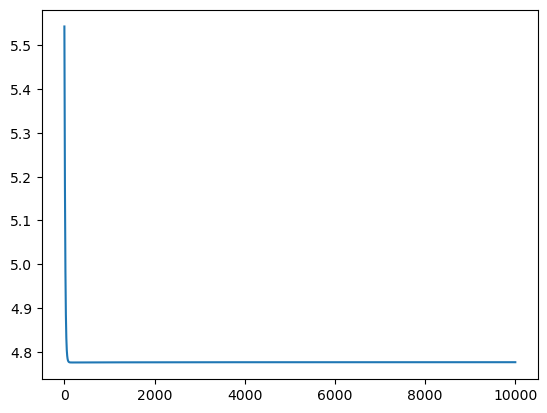

In [131]:
plt.plot(rhs)

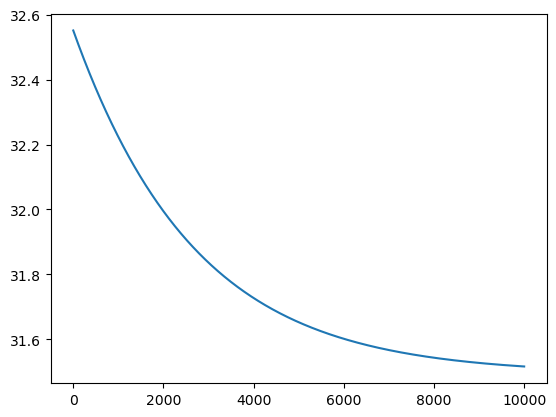

In [132]:
plt.plot(mhs_0)

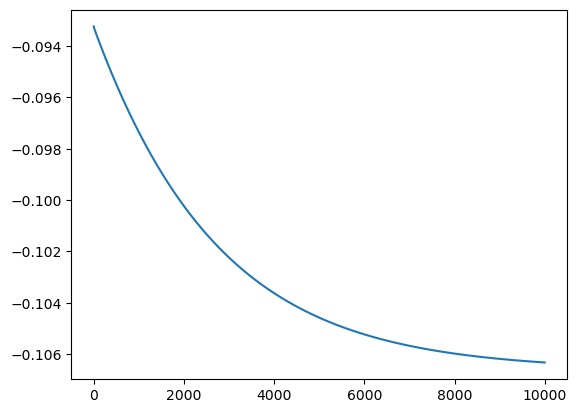

In [133]:
plt.plot(bhs[:,0])

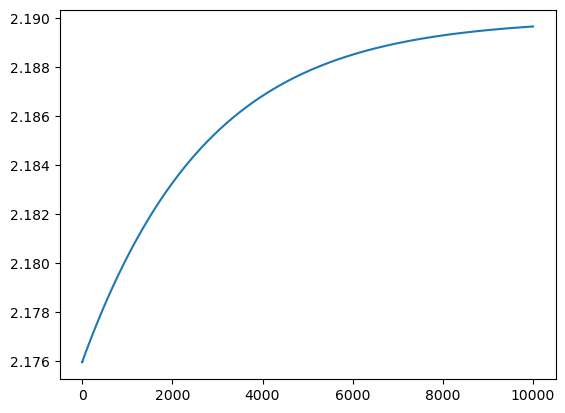

In [134]:
plt.plot(bhs[:,1])

## iteration

In [52]:
rsim = np.zeros([num_sim, n_iter])
msim_0 = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [53]:
Ys_sim = np.zeros([num_sim, T])

In [139]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    eps_sim = np.random.multivariate_normal(np.zeros(T), Sigma_eps)
    Y_sim = np.around(np.maximum(EY + np.sqrt(VYbT)*eps_sim,0)).astype(int)

    rhat, mhat_0, bhat =\
        fit(Y_sim, rinit=rmle, minit_0 = mmle_0, binit = bmle,
            history=True, n_iter=n_iter, step_size=1) 
    
    msim_0[iter_sim] = mhat_0
    rsim[iter_sim] = rhat
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 69.153943 sec.
2-th simulation finished, 61.641147 sec.
3-th simulation finished, 61.127505 sec.
4-th simulation finished, 64.790749 sec.
5-th simulation finished, 68.152287 sec.
6-th simulation finished, 69.559909 sec.
7-th simulation finished, 66.109220 sec.
8-th simulation finished, 65.749328 sec.
9-th simulation finished, 68.621048 sec.
10-th simulation finished, 71.292158 sec.
11-th simulation finished, 68.847393 sec.
12-th simulation finished, 67.245572 sec.
13-th simulation finished, 67.317499 sec.
14-th simulation finished, 68.079950 sec.
15-th simulation finished, 66.197356 sec.
16-th simulation finished, 66.744747 sec.
17-th simulation finished, 67.040681 sec.
18-th simulation finished, 66.801915 sec.
19-th simulation finished, 69.156059 sec.
20-th simulation finished, 75.824768 sec.
21-th simulation finished, 78.982056 sec.
22-th simulation finished, 78.205944 sec.
23-th simulation finished, 87.595906 sec.
24-th simulation finished, 71.019750 sec.
2

194-th simulation finished, 75.960628 sec.
195-th simulation finished, 80.931348 sec.
196-th simulation finished, 76.487003 sec.
197-th simulation finished, 76.970509 sec.
198-th simulation finished, 76.906736 sec.
199-th simulation finished, 76.817101 sec.
200-th simulation finished, 76.273674 sec.
201-th simulation finished, 77.189289 sec.
202-th simulation finished, 76.806561 sec.
203-th simulation finished, 77.100094 sec.
204-th simulation finished, 77.207442 sec.
205-th simulation finished, 83.373128 sec.
206-th simulation finished, 75.291481 sec.
207-th simulation finished, 73.910498 sec.
208-th simulation finished, 74.593095 sec.
209-th simulation finished, 73.485081 sec.
210-th simulation finished, 75.080644 sec.
211-th simulation finished, 82.489221 sec.
212-th simulation finished, 75.583787 sec.
213-th simulation finished, 74.927689 sec.
214-th simulation finished, 71.881451 sec.
215-th simulation finished, 71.486711 sec.
216-th simulation finished, 71.469390 sec.
217-th simu

384-th simulation finished, 68.828690 sec.
385-th simulation finished, 70.253314 sec.
386-th simulation finished, 69.478997 sec.
387-th simulation finished, 69.516777 sec.
388-th simulation finished, 69.102933 sec.
389-th simulation finished, 69.381496 sec.
390-th simulation finished, 69.338768 sec.
391-th simulation finished, 68.190687 sec.
392-th simulation finished, 68.154171 sec.
393-th simulation finished, 68.604005 sec.
394-th simulation finished, 67.956185 sec.
395-th simulation finished, 70.403813 sec.
396-th simulation finished, 68.327845 sec.
397-th simulation finished, 70.130067 sec.
398-th simulation finished, 74.866434 sec.
399-th simulation finished, 69.783336 sec.
400-th simulation finished, 69.943740 sec.
401-th simulation finished, 68.395485 sec.
402-th simulation finished, 68.382207 sec.
403-th simulation finished, 71.916955 sec.
404-th simulation finished, 69.184569 sec.
405-th simulation finished, 67.719820 sec.
406-th simulation finished, 68.849170 sec.
407-th simu

575-th simulation finished, 70.451650 sec.
576-th simulation finished, 69.770020 sec.
577-th simulation finished, 76.664827 sec.
578-th simulation finished, 74.165939 sec.
579-th simulation finished, 74.581876 sec.
580-th simulation finished, 80.547168 sec.
581-th simulation finished, 80.818080 sec.
582-th simulation finished, 75.089673 sec.
583-th simulation finished, 76.091811 sec.
584-th simulation finished, 74.282997 sec.
585-th simulation finished, 70.009521 sec.
586-th simulation finished, 68.853548 sec.
587-th simulation finished, 68.326497 sec.
588-th simulation finished, 68.856889 sec.
589-th simulation finished, 69.427740 sec.
590-th simulation finished, 69.221467 sec.
591-th simulation finished, 70.173709 sec.
592-th simulation finished, 69.952388 sec.
593-th simulation finished, 68.641697 sec.
594-th simulation finished, 68.964915 sec.
595-th simulation finished, 68.731326 sec.
596-th simulation finished, 67.996553 sec.
597-th simulation finished, 68.437093 sec.
598-th simu

766-th simulation finished, 73.023257 sec.
767-th simulation finished, 67.299185 sec.
768-th simulation finished, 67.285112 sec.
769-th simulation finished, 68.310202 sec.
770-th simulation finished, 71.390235 sec.
771-th simulation finished, 68.867741 sec.
772-th simulation finished, 71.294100 sec.
773-th simulation finished, 68.328333 sec.
774-th simulation finished, 69.026914 sec.
775-th simulation finished, 67.986160 sec.
776-th simulation finished, 68.728694 sec.
777-th simulation finished, 68.394279 sec.
778-th simulation finished, 73.197199 sec.
779-th simulation finished, 71.102110 sec.
780-th simulation finished, 72.575726 sec.
781-th simulation finished, 72.803888 sec.
782-th simulation finished, 70.636169 sec.
783-th simulation finished, 72.229750 sec.
784-th simulation finished, 75.507642 sec.
785-th simulation finished, 74.458232 sec.
786-th simulation finished, 83.172413 sec.
787-th simulation finished, 77.336668 sec.
788-th simulation finished, 74.137846 sec.
789-th simu

KeyboardInterrupt: 

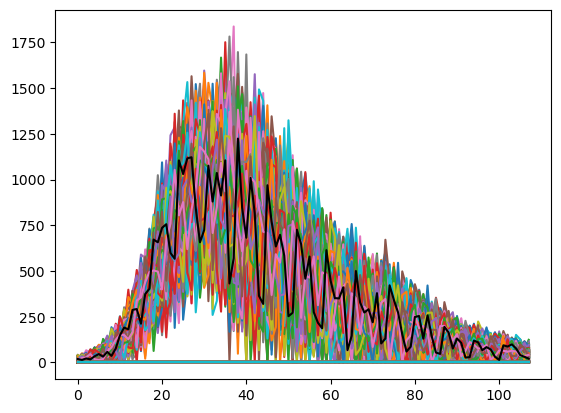

In [140]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [55]:
id_valid = (rsim[:,0] > 0)

(array([138., 280., 230., 156.,  76.,  31.,  11.,   3.,   0.,   2.]),
 array([ 1.27677996,  2.88334637,  4.48991277,  6.09647918,  7.70304558,
         9.30961199, 10.91617839, 12.5227448 , 14.1293112 , 15.73587761,
        17.34244401]),
 <BarContainer object of 10 artists>)

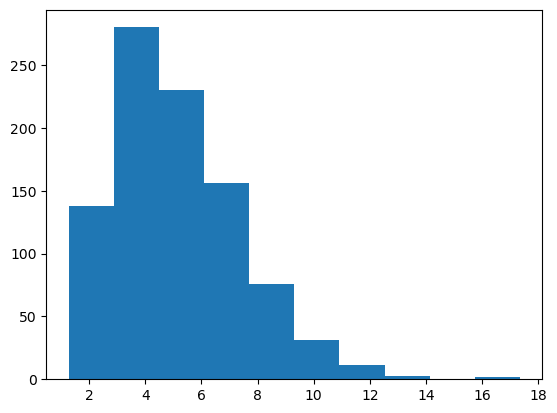

In [56]:
plt.hist(rsim[id_valid,-1])

(array([  5.,  16.,  63., 151., 187., 187., 166.,  91.,  50.,  11.]),
 array([ 9.65119667, 14.04702257, 18.44284847, 22.83867437, 27.23450027,
        31.63032617, 36.02615207, 40.42197797, 44.81780388, 49.21362978,
        53.60945568]),
 <BarContainer object of 10 artists>)

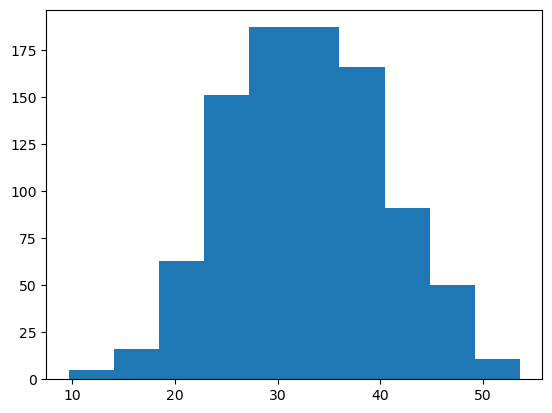

In [57]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

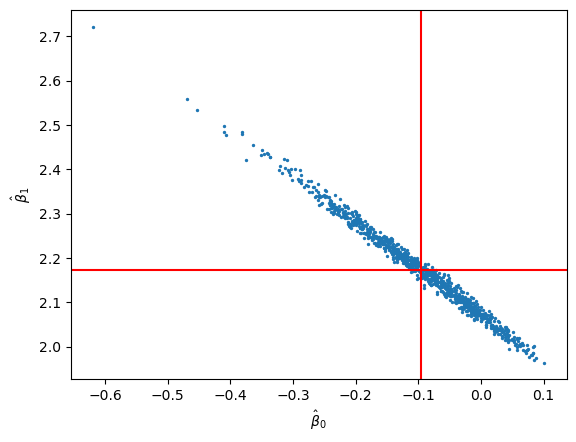

In [58]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=bmle[1], color='red')
plt.axvline(x=bmle[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

In [59]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.09735669800860225

In [60]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.10261271871851163

In [61]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.00947833, -0.00993307],
       [-0.00993307,  0.01052937]])

In [62]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

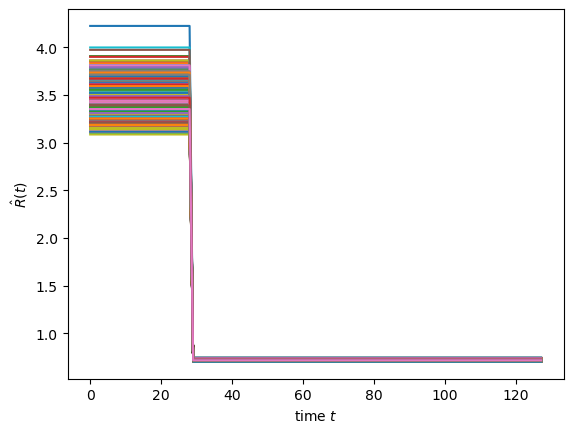

In [63]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [97]:
# np.savez("result_nonparametric_negative_binomial.npz",
#          mmle_0 = mmle_0, rmle = rmle, bmle = bmle,
#          mhs_0 = mhs_0, rhs = rhs, bhs = bhs,
#          msim_0 = msim_0, rsim = rsim, bsim = bsim,
#          Ys_sim = Ys_sim, pi = pi, g = g, A = A)

In [54]:
locals().update(np.load("result_nonparametric_negative_binomial.npz"))

# 5. Wald's Confidence Region coverage test

In [64]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [65]:
for t in np.arange(T+T0):
    o = np.exp(bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = - K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

In [66]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [67]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [68]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [69]:
Pi_inv_ImG = Pi @ inv_ImG

In [70]:
EY = mmle_0 * Pi_inv_ImG[:,0]

In [71]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [72]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [73]:
dldEY = Y_data/EY - (rmle+Y_data)/(rmle+EY)
d2ldEY2 = - Y_data/EY**2 + (rmle+Y_data)/(rmle+EY)**2
d2ldrdEY = - 1/(rmle+EY) + (rmle+Y_data)/(rmle+EY)**2

In [74]:
d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y_data, EY)])
d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
       + np.sum(dldEY * d2EY, 2)

d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
        + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

In [75]:
d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                    [d2ldrdm, d2ldm2]])
d2ldrmdb = np.stack([d2ldrdb, 
                     d2ldmdb])

In [76]:
Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                       [d2ldrmdb.T, d2ldb2]])

In [77]:
np.sqrt(la.inv(Ihat_dth)[2,2])

0.11880910507799937

In [78]:
np.sqrt(la.inv(Ihat_dth)[3,3])

0.12822034325107315

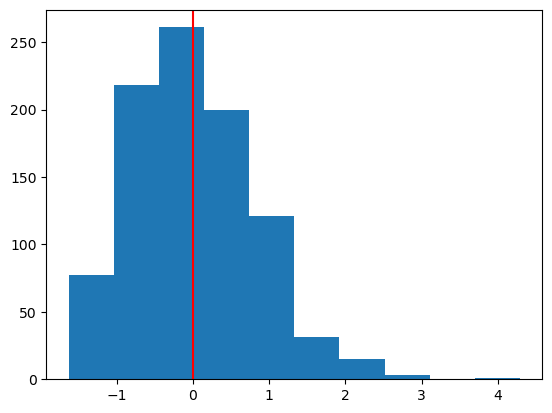

In [81]:
plt.hist((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_dth)[3,3]))
plt.axvline(x=0, c='red')

In [96]:
np.mean(np.abs((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_dth)[3,3])) <= 1.96)

0.9816612729234089

In [ ]:
scipy.stats.norm

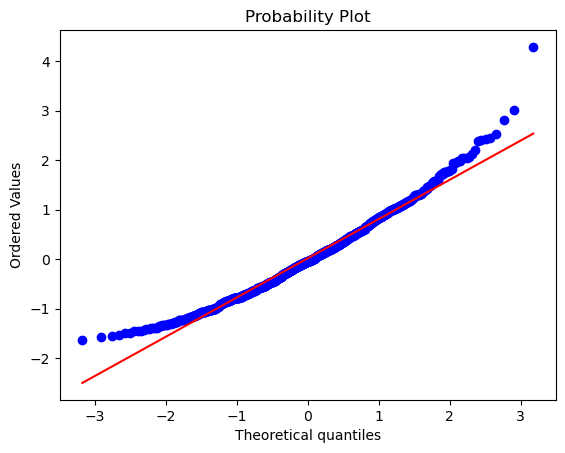

In [82]:
stats.probplot((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_dth)[3,3]),
               dist = 'norm', plot=plt)
plt.show()

# 6. Sandwich estimator coverage test

In [83]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [84]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [85]:
dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
dltdm = dldEY * Pi_inv_ImG[:,0]
dltdb = dldEY * d1EY

In [86]:
dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)

In [87]:
VEdl = dltdth @ w_HAC @ dltdth.T

In [88]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [89]:
np.sqrt(la.inv(Ihat_sdw)[2,2])

0.06782767097548142

In [90]:
np.sqrt(la.inv(Ihat_sdw)[3,3])

0.07671608142671438

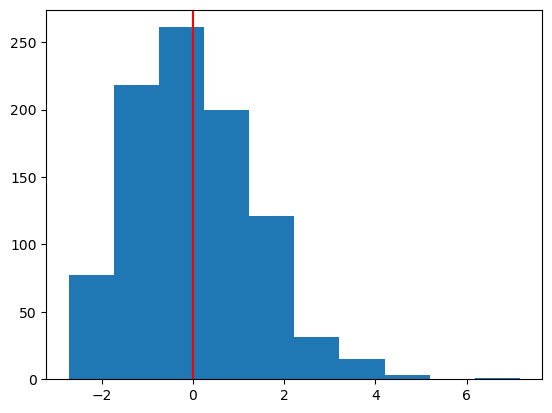

In [91]:
plt.hist((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_sdw)[3,3]))
plt.axvline(x=0, c='red')

In [95]:
np.mean(np.abs((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_sdw)[3,3])) <= 1.96)

0.8748651564185544

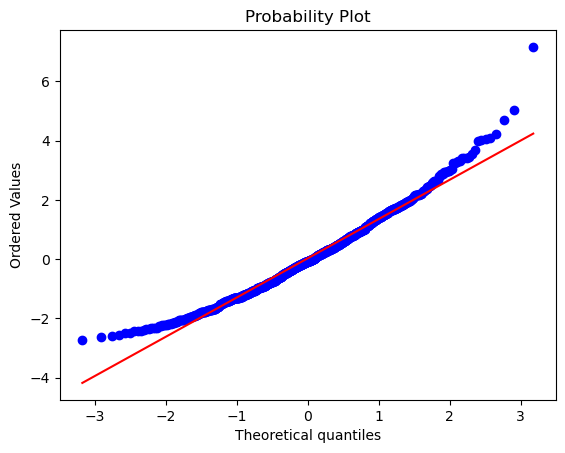

In [92]:
stats.probplot((bsim[id_valid,-1,1]-bmle[1])/np.sqrt(la.inv(Ihat_sdw)[3,3]),
               dist = 'norm', plot=plt)
plt.show()